
# **Assessing Coupling of Trophic Position (TP) and δ<sup>15</sup>N<sub>Phe</sub> in paleoarchives**



# --------------------------------------------------------------------------------------

# **1. Load packages, set default plotting parameters and define helper functions**



### Load packages


In [1]:
#Load packages

import scipy
import scipy.integrate

import xarray as xr 

from xgcm import Grid

import pandas as pd

import statsmodels
import statsmodels.api as sm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import FixedLocator, FormatStrFormatter
from matplotlib.ticker import AutoMinorLocator
from matplotlib import colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

import numpy as np
import random as rand

import statsmodels.tsa.api as smt

from pyleoclim import utils
#from pyleoclim import tsutils
from pyleoclim.utils import tsutils
matplotlib.rcParams.update(plt.rcParamsDefault)

import cmocean

import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature

import sympy as sym

from types import SimpleNamespace   


### Set default font properties for plots


In [2]:
#set default font properties and sizes for plots

matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman']
font = {'weight' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)
half_width=3.5 #width of 1/2 page figure
full_width=7 #with of full page figure


### define helper functions to use in subsequent analyses


In [3]:
"""
function to calculate trophic position
"""
def TP(Glu,Phe,beta=3.4,d=3.4,TDF=7.6,coral=True):
    if coral == True:
        TP_val=((Glu+d-Phe-beta)/TDF)+1
    if coral == False:
        TP_val=((Glu-Phe-beta)/TDF)+1
    return TP_val

"""
function to calculate trophic position
from Glu and Lys
TEF is using conventional 8.0 permil TEF for Glu (chikariashi et al., 2009)
and McMahon & McCarthy 2016 estimate of Lys TEF
Beta is from Ramirez et al. 2021 value for marine eukaryotic algae
d is from McMahon et al., 2018 coral paper
"""
def TP_Lys(Glu,Lys,beta=4.6,d=3.4,TDF=7.2,coral=True):
    if coral == True:
        TP_val=((Glu+d-Lys-beta)/TDF)+1
    if coral == False:
        TP_val=((Glu-Lys-beta)/TDF)+1
    return TP_val

"""
function to calculate spearman correlation coefficient
"""
def rho_calc(TP_series,Phe_series):
    rho=scipy.stats.spearmanr(TP_series,Phe_series)[0]
    return rho

"""
function to calculate linear regression slope
"""
def slope_calc(TP_series,Phe_series):
    slope=scipy.stats.linregress(TP_series,Phe_series)[0]
    return slope

"""
function to calculate linear regression intercept
"""
def intercept_calc(TP_series,Phe_series):
    intercept=scipy.stats.linregress(TP_series,Phe_series)[1]
    return intercept

"""
function to estimate lag-1 autocorrelation from irregularly spaced timeseries
"""
def lag1ac(age,y,step_mult=0.9):
    y_vals,time_vals=y.values,age.values
    step_width=(max(time_vals)-min(time_vals))/len(time_vals)
    y_interp_time,y_interp=tsutils.interp(time_vals, y_vals, interp_type='nearest',
                                          stop=max(time_vals)+(step_width/2), 
                                          #step_style='median',
                                          step=step_width*step_mult,
                                          bounds_error=False,fill_value='extrapolate')
    lag1ac=smt.acf(y_interp,nlags=1,fft=True)[1]
    return lag1ac,y_interp_time,y_interp

"""
function that scales a data series between 
specified low and high values
"""
def scale(series,low,high):
    newseries=(high-low)*((series-min(series))/(max(series)-min(series)))+low
    return newseries

"""
Function that finds the Coefficient of
Determination (R^2) fit between a line 
with given slope and intercept (m and b) and
a set of observations (given by x_obs and y_obs)
"""
def r2_func(x_obs, y_obs, m, b):
    y_pred = m*x_obs+b
    # sum of squares of residuals
    ssr=np.sum((y_obs-y_pred)**2)
    # total sum of squares
    sst=np.sum((y_obs-np.mean(y_obs))**2)
    return(1-(ssr/sst))

"""
Function that finds root of the mean squared error
between a line 
with given slope and intercept (m and b) and
a set of observations (given by x_obs and y_obs)
"""
def rmse_func(x_obs, y_obs, m, b):
    y_pred = m*x_obs+b
    n=len(x_obs)
    rmse=np.sqrt(np.sum((y_obs-y_pred)**2)/n)
    return(rmse)

"""
Function to simulate TP and Phe measurements, which we will use 
for probability estimation/significance testing
to quantify probability of obtaining given TP-Phe 
correlations and regression slopes from random chance
(based on known sources of uncertainty in TP and Phe measurements)
"""
def TP_Phe_simulation(n=30,                         # length of simulated timeseries
                      nsims=10000,                  # number of simulated timeseries to generate
                      corrtest='spearman',          # options 'pearson' or 'spearman'
                      uncertainty_dist='normal',    # options 'normal' or 'uniform'
                      TP_range=[2.2,2.8],           # range of TP values to draw between
                      baseline_range=[8.5,10.5],    #if baseline_variability=False can just be single number

                      # TEF values for Glu and Phe
                      # from Chikaraishi et al., 2009
                      Phe_TEF=0.4, Glu_TEF=8.0,
                      Phe_TEF_std=0.5,Glu_TEF_std=1.2,

                      # lag-1 autocorrelation coefficients
                      # for simulated TP and Phe timeseries
                      # set to 0 if don't want to include 
                      # autocorrelation in simulations
                      #lag1ac_Phe only relevant if baseline_variability=True
                      lag1ac_TP=0,lag1ac_baseline=0, 

                      # Uncertainty from repeated triplicate measurements
                      # of long-term McCarthy lab cyanobacteria standard 
                      # over 5 years (Christensen et al., 2023)
                      Glu_meas_std=0.6,Phe_meas_std=0.7,
                            
                      # nonvascular autotroph beta and uncertainty
                      # from Ramirez et al. 2021
                      beta=3.4, beta_std=1.8,  

                      # correction for polyp-skeleton offset, 
                      # from McMahon et al. 2018
                      d=3.4,d_std=0.1,   

                      # should d15N baseline vary through time?
                      baseline_variability=False,

                      # is the simualtion for a coral?
                      # if so will account for d uncertainty
                      coral=True):
    """
    initialize empty lists to
    # populate in loop below
    """
    Phe_sims=[]
    Glu_sims=[]
    TP_sims=[]
    rho_Phe_sims=[]
    slope_Phe_sims=[]
    rho_Glu_sims=[]
    slope_Glu_sims=[]

    """
    Autocorrelation info from parameters
    """
    #autocorrelation info for TP timeseries 
    ar_TP = [1, -lag1ac_TP]  # AR model parameter
    ma_TP = [1, 0.0] # MA model parameters
    
    #autocorrelation info for Phe timeseries 
    ar_baseline = [1, -lag1ac_baseline]  # AR model parameter
    ma_baseline = [1, 0.0] # MA model parameters

    """
    Generate specified number (nsims) of simulated time series of 
    measured TP and Phe of length n, accounting for various sources 
    of uncertainty and possibilities. These simulations will
    be used to calculate the probability of finding a given TP-Phe
    slope and correlation coefficient due to statistical artifact
    """
    
    for i in range(0,nsims):
            """
            first we generate "true" values 
            for the TP timeseries that represent
            the actual trophic position of the coral
            or sediment based on the parameters
            TP_range and lag1ac_TP
            """
            if lag1ac_TP == 0:
                # generates TP timeseries drawn from uniform distribution
                # with specified TP_range
                TP_true=np.random.uniform(TP_range[0], TP_range[1], n)
            else:
                # generates TP timeseries with specified lag-1ac, 
                TP_true=smt.arma_generate_sample(ar_TP, ma_TP, nsample=n,
                                                 distrvs=np.random.uniform,
                                                 burnin=300)
                TP_true=scale(TP_true,low=TP_range[0],high=TP_range[1])

            """
            Then we generate true values for d15N baseline
            (ie d15N Phe in phytoplankton) based on parameters
            baseline_range, baseline_variability and lag1ac_baseline
            """
            if baseline_variability == True:
                if lag1ac_baseline == 0:
                    # generates baseline timeseries drawn from uniform distribution
                    # with specified baseline_range
                    Phe_baseline=np.random.uniform(baseline_range[0], baseline_range[1], n)
                else:
                    #generate baseline timeseries with specified lag-1 ac (lag1ac_baseline)
                    Phe_baseline=smt.arma_generate_sample(ar_baseline, ma_baseline, nsample=n,
                                                            distrvs=np.random.uniform,
                                                            burnin=500)
                    #scale generated baseline timeseries between baseline_range values
                    Phe_baseline=scale(Phe_baseline,low=baseline_range[0],high=baseline_range[1])
            elif baseline_variability == False:
               # generates Phe timeseries drawn from uniform distribution
                Phe_baseline=np.full(n,np.mean(baseline_range))

            """ 
            Calculate TEF values to use to calculate Glu and Phe based on 
            specified values of TEF uncertainty(from parameters 
            Glu_TEF, Phe_TEF, Glu_TEF_std and Phe_TEF_std)
            """
            TEF_Glu=np.full(n,Glu_TEF)
            TEF_Phe=np.full(n,Phe_TEF)
            if uncertainty_dist == 'uniform':
                TEF_Glu=TEF_Glu+np.random.uniform(-Glu_TEF_std,Glu_TEF_std, n)
                TEF_Phe=TEF_Phe+np.random.uniform(-Phe_TEF_std,Phe_TEF_std, n)
            elif uncertainty_dist == 'normal':
                TEF_Glu=TEF_Glu+np.random.normal(0, Glu_TEF_std, n)
                TEF_Phe=TEF_Phe+np.random.normal(0, Phe_TEF_std, n)
            
            """ 
            Calculate Beta values to apply to Glu later
            accounting for uncertainty in Beta as specified by 
            beta and beta_std parameters
            """
            if uncertainty_dist == 'uniform':
                beta=beta+np.random.uniform(-2*beta_std,2*beta_std, n)
            elif uncertainty_dist == 'normal':
                beta=beta+np.random.normal(0, beta_std, n)
                
            """ 
            Calculate d values to apply to Glu later
            accounting for uncertainty d, the Glu offset between
            polyp and coral skeleton tissues
            """
            if coral == True:
                if uncertainty_dist == 'uniform':
                    d=d+np.random.uniform(-2*d_std,2*d_std, n)
                elif uncertainty_dist == 'normal':
                    d=d+np.random.normal(0, d_std, n)
            
            """ 
            Accounting for uncertainty in all TP parameters as calculated above
            (TEF, beta, d), calculate "true" values of d15N Glu and d15N Phe 
            in the simulated paleoceanographic timeseries from TP_true and Phe_baseline
            """
            Phe_true=Phe_baseline+((TP_true-1)*TEF_Phe)
            if coral == True:
                Glu_true=Phe_baseline+((TP_true-1)*TEF_Glu)+beta-d
            elif coral == False:
                Glu_true=Phe_baseline+((TP_true-1)*TEF_Glu)+beta
            
            """ 
            Calculate measured values for d15N Phe and d15N Glu,
            accounting for measurement uncertainty
            """
            if uncertainty_dist == 'uniform':
                Phe_meas=Phe_true+np.random.uniform(-2*Phe_meas_std, 2*Phe_meas_std, n)
                Glu_meas=Glu_true+np.random.uniform(-2*Glu_meas_std, 2*Glu_meas_std, n)
            elif uncertainty_dist == 'normal':
                Phe_meas=Phe_true+np.random.normal(0, Phe_meas_std, n)
                Glu_meas=Glu_true+np.random.normal(0, Glu_meas_std, n)
            
            """ 
            Calculate measured values for TP, using Glu_meas, Phe_meas
            and parameters clasically used for TP estimation 
            """
            if coral == True:
                TP_meas=TP(Glu=Glu_meas,Phe=Phe_meas,beta=3.4,d=3.4,TDF=7.6,coral=True)
            elif coral == False:
                TP_meas=TP(Glu=Glu_meas,Phe=Phe_meas,beta=3.4,TDF=7.6,coral=False)
            
            """ 
            Calculate correlation coefficient between 
            TP and d15N Phe in measured simulated timeseries
            """
            if corrtest == 'pearson':
                rho_Phe=scipy.stats.pearsonr(TP_meas,Phe_meas)[0]
                rho_Glu=scipy.stats.pearsonr(TP_meas,Glu_meas)[0]
            if corrtest == 'spearman':
                rho_Phe=scipy.stats.spearmanr(TP_meas,Phe_meas)[0]
                rho_Glu=scipy.stats.spearmanr(TP_meas,Glu_meas)[0]
                
            """ 
            Calculate slope of regression between TP and Phe 
            in measured simulated timeseries
            """
            slope_Phe=scipy.stats.linregress(TP_meas,Phe_meas)[0]
            slope_Glu=scipy.stats.linregress(TP_meas,Glu_meas)[0]
                
            """ 
            Save results to empty lists defined above
            """
            Glu_sims.append(Glu_meas)
            Phe_sims.append(Phe_meas)
            TP_sims.append(TP_meas)
            rho_Phe_sims.append(rho_Phe)
            rho_Glu_sims.append(rho_Glu)
            slope_Phe_sims.append(slope_Phe)
            slope_Glu_sims.append(slope_Glu)

            
    return Phe_sims,Glu_sims,TP_sims,rho_Phe_sims,slope_Phe_sims,rho_Glu_sims,slope_Glu_sims

"""
function that plots a 2d 95% confidence ellipse 
# taken from: https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
"""
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    from matplotlib.patches import Ellipse
    import matplotlib.transforms as transforms
    
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# -----------------------------------------------------------------------------------------

# **2. Mass Balance Ecosystem δ<sup>15</sup>N Modeling**

# **What does a simple ecosystem mass-balance model predict about inherent coupling of TP and δ<sup>15</sup>N<sub>Phe</sub> in paleoarchives?**


## **Section 2.1**

## Here we define the δ<sup>15</sup>N ecosystem mass balance model we will use to explore relationships between TP and δ<sup>15</sup>N<sub>Phe</sub> in paleoarchives. The model has a similar structure to a simple Nutrient-Phytoplankton-Zooplankton (NPZ) model; however our model is strictly mass-balance and does not time-step, nor does it rely on input environmental conditions like nutrient concentrations, temperature, light, etc. 

## Instead, the model is forced by TP and nutrient utilization inputs that shift the composition of the euphotic zone biological community, influencing the relative abundance of phytoplankton, grazers, predators, nitrate and ammonium. Processes represented in the model include nitrate and ammonium uptake by phytoplankton, ammonium excretion by both zooplankton classes, grazing and predation.


### We will first use the **sympy** python package to define and solve the two systems of equations that comprise the mass balance model and get symbolic solutions we can call in a function.

### Starting with the system of equations that describes <ins>**the fraction of total nitrogen**</ins> (f) that partitions into 5 nitrogen pools: residual nitrate (rNO3), residual ammonium (rNH4), phytoplankton (phy), grazing zooplankton (zoo1) and predator zooplankton (zoo2):


In [4]:
''' 
define symbols to be solved for
in this case, the fraction of total nitrogen
in each of the 4 unknown nitrogen pools, and the
fraction of total nitrogen that is ingested via 
grazing and predation. In some cases grazing and
predation could be >1 due to nutrient recycling.
note: the fraction of residual NO3 (f_rNO3) 
is given as an input parameter, not solved for.
We also solve for the fraction of new and recycled 
production. 
'''
f_rNO3_ = sym.symbols('f_rNO3_',real=True,positive=True)
f_rNH4_ = sym.symbols('f_rNH4_',real=True,positive=True)
f_phy_ = sym.symbols('f_phy_',real=True,positive=True)
f_zoo1_ = sym.symbols('f_zoo1_',real=True,positive=True)
f_zoo2_ = sym.symbols('f_zoo2_',real=True,positive=True)
f_grazing_ = sym.symbols('f_grazing_',real=True,positive=True)
f_predation_ = sym.symbols('f_predation_',real=True,positive=True)
f_newP_ = sym.symbols('f_newP_',real=True,positive=True)
f_recP_ = sym.symbols('f_recP_',real=True,positive=True)
f_ratio_ = sym.symbols('f_ratio_',real=True,positive=True)

'''
define symbols for constants and parameters
f_rNO3=the fraction of residual nitrate,
p_exc=proportion of zooplankton diet that's excreted as NH4
p_NH4=the proportion of initial NH4 that is utilized by phytoplankton
TP=average ecosystem trophic position, assumed to reflect relative 
proportions of phytoplankton, grazers and predator zooplankton 
'''
p_NO3_,p_exc_,p_NH4_,TP_ = sym.symbols('p_NO3_, p_exc_, p_NH4_, TP_', real=True, positive=True)

'''
define the equations for fractions in each nitrogen pool
in sympy equalities
'''
eq1 = sym.Eq(1,f_phy_+f_zoo1_+f_zoo2_+f_rNH4_+f_rNO3_)
eq2 = sym.Eq(f_rNO3_,1-p_NO3_)
eq3 = sym.Eq(f_zoo1_,f_grazing_*(1-p_exc_)-f_predation_)
eq4 = sym.Eq(f_zoo2_,f_predation_*(1-p_exc_))
eq5 = sym.Eq(f_rNH4_,p_exc_*(f_grazing_+f_predation_)*(1-p_NH4_))
eq6 = sym.Eq(f_phy_,f_recP_+f_newP_-f_grazing_)
eq7 = sym.Eq(f_recP_,p_exc_*(f_grazing_+f_predation_)*p_NH4_)
eq8 = sym.Eq(f_newP_,p_NO3_)
eq9 = sym.Eq(TP_,(1*f_phy_+2*f_zoo1_+3*f_zoo2_)/(f_phy_+f_zoo1_+f_zoo2_))
eq10 = sym.Eq(f_zoo1_/(f_zoo1_+f_zoo2_),-TP_/2+1.5)
eq11 = sym.Eq(f_ratio_,f_newP_/(f_newP_+f_recP_))

'''
display the equations that define the fractions model
'''
print('Fraction System of Equations:')
for i in [eq1,eq2,eq3,eq4,eq5,eq6,eq7,eq8,eq9,eq10,eq11]:
    display(i)

'''
solve the fractions system of equations algebraically 
'''
solution = sym.solve([eq1,eq2,eq3,eq4,eq5,eq6,eq7,eq8,eq9,eq10],
                     (f_rNO3_,f_rNH4_,f_zoo1_,f_zoo2_,f_phy_,f_grazing_,f_predation_,f_newP_,f_recP_),
                     dict=True,force=True)
solution_fratio = sym.solve(eq11,(f_ratio_),dict=True)
'''
display algebraic solutions
and save each solution as a callable function
using the sympy lambdify function
'''
f_solution_dict = {}
print('\nFraction System of Equations Solutions:')
for i in [f_rNO3_,f_rNH4_,f_zoo1_,f_zoo2_,f_phy_,f_grazing_,f_predation_,f_newP_,f_recP_]:
    f_solution_dict[format(i)] = sym.lambdify((p_NO3_,p_exc_,p_NH4_,TP_),solution[0][i])
    display(sym.Eq(i,solution[0][i]))

f_solution_dict[format(f_ratio_)] = sym.lambdify((f_newP_,f_recP_),solution_fratio[0][f_ratio_])
display(sym.Eq(f_ratio_,solution_fratio[0][f_ratio_]))

Fraction System of Equations:


Eq(1, f_phy_ + f_rNH4_ + f_rNO3_ + f_zoo1_ + f_zoo2_)

Eq(f_rNO3_, 1 - p_NO3_)

Eq(f_zoo1_, f_grazing_*(1 - p_exc_) - f_predation_)

Eq(f_zoo2_, f_predation_*(1 - p_exc_))

Eq(f_rNH4_, p_exc_*(1 - p_NH4_)*(f_grazing_ + f_predation_))

Eq(f_phy_, -f_grazing_ + f_newP_ + f_recP_)

Eq(f_recP_, p_NH4_*p_exc_*(f_grazing_ + f_predation_))

Eq(f_newP_, p_NO3_)

Eq(TP_, (f_phy_ + 2*f_zoo1_ + 3*f_zoo2_)/(f_phy_ + f_zoo1_ + f_zoo2_))

Eq(f_zoo1_/(f_zoo1_ + f_zoo2_), 1.5 - TP_/2)

Eq(f_ratio_, f_newP_/(f_newP_ + f_recP_))


Fraction System of Equations Solutions:


Eq(f_rNO3_, 1.0 - p_NO3_)

Eq(f_rNH4_, p_NO3_*p_exc_*(TP_**2*p_NH4_ - TP_**2 - 2.0*TP_*p_NH4_*p_exc_ + 2.0*TP_*p_exc_ + 2.0*p_NH4_*p_exc_ - p_NH4_ - 2.0*p_exc_ + 1.0)/(TP_**2*p_NH4_*p_exc_ - TP_**2*p_exc_ - 2.0*TP_*p_NH4_*p_exc_**2 + TP_*p_exc_**2 + 2.0*TP_*p_exc_ - TP_ + 2.0*p_NH4_*p_exc_**2 - p_NH4_*p_exc_ - 3.0*p_exc_**2 + 3.0*p_exc_ - 1.0))

Eq(f_zoo1_, p_NO3_*(TP_**2*p_exc_**2 - 2.0*TP_**2*p_exc_ + TP_**2 - 4.0*TP_*p_exc_**2 + 8.0*TP_*p_exc_ - 4.0*TP_ + 3.0*p_exc_**2 - 6.0*p_exc_ + 3.0)/(TP_**2*p_NH4_*p_exc_ - TP_**2*p_exc_ - 2.0*TP_*p_NH4_*p_exc_**2 + TP_*p_exc_**2 + 2.0*TP_*p_exc_ - TP_ + 2.0*p_NH4_*p_exc_**2 - p_NH4_*p_exc_ - 3.0*p_exc_**2 + 3.0*p_exc_ - 1.0))

Eq(f_zoo2_, p_NO3_*(TP_**2*p_exc_**2 - 2.0*TP_**2*p_exc_ + TP_**2 - 2.0*TP_*p_exc_**2 + 4.0*TP_*p_exc_ - 2.0*TP_ + p_exc_**2 - 2.0*p_exc_ + 1.0)/(-TP_**2*p_NH4_*p_exc_ + TP_**2*p_exc_ + 2.0*TP_*p_NH4_*p_exc_**2 - TP_*p_exc_**2 - 2.0*TP_*p_exc_ + TP_ - 2.0*p_NH4_*p_exc_**2 + p_NH4_*p_exc_ + 3.0*p_exc_**2 - 3.0*p_exc_ + 1.0))

Eq(f_phy_, p_NO3_*(TP_*p_exc_**2 - 2.0*TP_*p_exc_ + TP_ - 3.0*p_exc_**2 + 6.0*p_exc_ - 3.0)/(TP_**2*p_NH4_*p_exc_ - TP_**2*p_exc_ - 2.0*TP_*p_NH4_*p_exc_**2 + TP_*p_exc_**2 + 2.0*TP_*p_exc_ - TP_ + 2.0*p_NH4_*p_exc_**2 - p_NH4_*p_exc_ - 3.0*p_exc_**2 + 3.0*p_exc_ - 1.0))

Eq(f_grazing_, p_NO3_*(TP_**2*p_exc_ - 4.0*TP_*p_exc_ + 2.0*TP_ + 3.0*p_exc_ - 2.0)/(-TP_**2*p_NH4_*p_exc_ + TP_**2*p_exc_ + 2.0*TP_*p_NH4_*p_exc_**2 - TP_*p_exc_**2 - 2.0*TP_*p_exc_ + TP_ - 2.0*p_NH4_*p_exc_**2 + p_NH4_*p_exc_ + 3.0*p_exc_**2 - 3.0*p_exc_ + 1.0))

Eq(f_predation_, p_NO3_*(TP_**2*p_exc_ - TP_**2 - 2.0*TP_*p_exc_ + 2.0*TP_ + p_exc_ - 1.0)/(TP_**2*p_NH4_*p_exc_ - TP_**2*p_exc_ - 2.0*TP_*p_NH4_*p_exc_**2 + TP_*p_exc_**2 + 2.0*TP_*p_exc_ - TP_ + 2.0*p_NH4_*p_exc_**2 - p_NH4_*p_exc_ - 3.0*p_exc_**2 + 3.0*p_exc_ - 1.0))

Eq(f_newP_, p_NO3_)

Eq(f_recP_, p_NH4_*p_NO3_*p_exc_*(TP_**2 - 2.0*TP_*p_exc_ + 2.0*p_exc_ - 1.0)/(-TP_**2*p_NH4_*p_exc_ + TP_**2*p_exc_ + 2.0*TP_*p_NH4_*p_exc_**2 - TP_*p_exc_**2 - 2.0*TP_*p_exc_ + TP_ - 2.0*p_NH4_*p_exc_**2 + p_NH4_*p_exc_ + 3.0*p_exc_**2 - 3.0*p_exc_ + 1.0))

Eq(f_ratio_, f_newP_/(f_newP_ + f_recP_))

### Next we do the same with the system of equations that describes <ins>**δ<sup>15</sup>N of nitrogen**</ins> (d) in each of the 5 nitrogen pools: residual nitrate (rNO3), residual ammonium (rNH4), phytoplankton (phy), grazing zooplankton (zoo1) and predator zooplankton (zoo2):

In [5]:
'''
define symbols to be solved for-
in this case, the nitrogen isotope variables. 
For this system of equations, the fractions
from the previously solved system will be
treated as inputs
'''
d_rNO3_ = sym.symbols('\delta^{15}\!N_{rNO3}',real=True)
d_rNH4_ = sym.symbols('\delta^{15}\!N_{rNH4}',real=True)
d_phy_  = sym.symbols('\delta^{15}\!N_{phy}',real=True)
d_zoo1_ = sym.symbols('\delta^{15}\!N_{zoo1}',real=True)
d_zoo2_ = sym.symbols('\delta^{15}\!N_{zoo2}',real=True)

'''
define symbols for inputs/parameters
'''
d_sNO3_                                = sym.symbols('\delta^{15}\!N_{sNO3}',real=True,positive=True)
f_rNO3_,f_rNH4_,f_phy_,f_zoo1_,f_zoo2_ = sym.symbols('f_rNO3_,f_rNH4_,f_phy_,f_zoo1_,f_zoo2_',
                                                     real=True,positive=True)
eps_assim1_,eps_assim2_,eps_exc_       = sym.symbols('epsilon_assim1_,epsilon_assim2_,epsilon_exc_',real=True)
p_exc_,p_NH4_,p_NO3_                   = sym.symbols('p_exc_,p_NH4_,p_NO3_,',real=True)

'''
define the equations for d15N of each nitrogen pool.
some of these equations have two possible versions,
one that employs rayleigh fractionation and one that
employs open-system fractionation formulations for 
phytoplankton NO3 or NH4 uptake. Equations that assume 
rayleigh fractionation are denoted with _r, and equations
that assume open-system fractionation are denoted _o

'''
eq15   = sym.Eq(d_sNO3_,f_phy_*d_phy_+f_zoo1_*d_zoo1_+f_zoo2_*d_zoo2_+
                f_rNH4_*d_rNH4_+f_rNO3_*d_rNO3_)
eq16_o  = sym.Eq(d_rNO3_,d_sNO3_+(eps_assim1_*(1-f_rNO3_)))
eq16_r  = sym.Eq(d_rNO3_,d_sNO3_-(eps_assim1_*(sym.log(f_rNO3_))))
eq17_o = sym.Eq(d_rNH4_,
                (((d_phy_-eps_exc_*(1-p_exc_))*(f_grazing_/(f_grazing_+f_predation_)))+
                 ((d_zoo1_-eps_exc_*(1-p_exc_))*(f_predation_/(f_grazing_+f_predation_)))+
                 (eps_assim2_*p_NH4_)))
eq17_r = sym.Eq(d_rNH4_,
                (((d_phy_-eps_exc_*(1-p_exc_))*(f_grazing_/(f_grazing_+f_predation_)))+
                 ((d_zoo1_-eps_exc_*(1-p_exc_))*(f_predation_/(f_grazing_+f_predation_)))-
                 (eps_assim2_*(sym.log(1-p_NH4_)))))
eq18    = sym.Eq(d_zoo1_,d_phy_+(p_exc_*eps_exc_))
eq19   = sym.Eq(d_zoo2_,d_zoo1_+(p_exc_*eps_exc_))


#display the equations that define the nitrogen isotope model
print('Isotope System of Equations (Assuming Rayleigh Fractionation for NO3 and NH4 uptake):')
print('(note that log in python refers to the natural log ln)')
for i in [eq15,eq16_r,eq17_r,eq18,eq19]:
    display(i)

print('\nIsotope System of Equations (Assuming Open System Fractionation for NO3 and NH4 uptake):')
for i in [eq15,eq16_o,eq17_o,eq18,eq19]:
    display(i)

'''
save equations for calculating d15N of residual nitrate (d_rNO3)
as callable functions. _r denotes a rayleigh fractionation solution,
_o denotes an open system fractionation solution.
'''
solution_rno3_r = sym.solve([eq16_r],(d_rNO3_),dict=True)
d_rNO3_solution_r = sym.lambdify((d_sNO3_,f_rNO3_,eps_assim1_),
                                 solution_rno3_r[0][d_rNO3_])

solution_rno3_o = sym.solve([eq16_o],(d_rNO3_),dict=True)
d_rNO3_solution_o = sym.lambdify((d_sNO3_,f_rNO3_,eps_assim1_),
                                 solution_rno3_o[0][d_rNO3_])

'''
solve the fractions system of equations algebraically 
and save solutions as callable functions 
~NH4 rayleigh fractionation solution~
'''
solution_r = sym.solve([eq15,eq17_r,eq18,eq19],(d_rNH4_,d_zoo1_,d_zoo2_,d_phy_),dict=True)

'''
display algebraic solutions
and save each solution as a callable function
using the sympy lambdify function
~NH4 rayleigh fractionation solution~
'''
print('\nIsotope System of Equations Solutions (Assuming Rayleigh Fractionation):')
d_solution_dict_r = {}
vars=[d_rNH4_,d_zoo1_,d_zoo2_,d_phy_]
var_names=['d_rNH4_','d_zoo1_','d_zoo2_','d_phy_']
for i in range(0,4):
    d_solution_dict_r[var_names[i]] = sym.lambdify((d_sNO3_,d_rNO3_,
                                                    f_rNO3_,f_rNH4_,f_phy_,f_zoo1_,
                                                    f_zoo2_,f_grazing_,f_predation_,
                                                    eps_assim2_,eps_exc_,p_exc_,p_NH4_),
                                                   solution_r[0][vars[i]])
    display(sym.Eq(vars[i],solution_r[0][vars[i]]))

'''
solve the fractions system of equations algebraically 
and save solutions as callable functions 
~NH4 open system fractionation solution~
'''
solution_o = sym.solve([eq15,eq17_o,eq18,eq19],(d_rNH4_,d_zoo1_,d_zoo2_,d_phy_),dict=True)

'''
display algebraic solutions
and save each solution as a callable function
using the sympy lambdify function
~NH4 open system fractionation solution~
'''
print('\nIsotope System of Equations Solutions (Assuming Open system Fractionation):')
d_solution_dict_o = {}
vars=[d_rNH4_,d_zoo1_,d_zoo2_,d_phy_]
var_names=['d_rNH4_','d_zoo1_','d_zoo2_','d_phy_']
for i in range(0,4):
    d_solution_dict_o[var_names[i]] = sym.lambdify((d_sNO3_,d_rNO3_,
                                                    f_rNO3_,f_rNH4_,f_phy_,f_zoo1_,
                                                    f_zoo2_,f_grazing_,f_predation_,
                                                    eps_assim2_,eps_exc_,p_exc_,p_NH4_),
                                                   solution_o[0][vars[i]])
    display(sym.Eq(vars[i],solution_o[0][vars[i]]))

Isotope System of Equations (Assuming Rayleigh Fractionation for NO3 and NH4 uptake):
(note that log in python refers to the natural log ln)


Eq(\delta^{15}\!N_{sNO3}, \delta^{15}\!N_{phy}*f_phy_ + \delta^{15}\!N_{rNH4}*f_rNH4_ + \delta^{15}\!N_{rNO3}*f_rNO3_ + \delta^{15}\!N_{zoo1}*f_zoo1_ + \delta^{15}\!N_{zoo2}*f_zoo2_)

Eq(\delta^{15}\!N_{rNO3}, \delta^{15}\!N_{sNO3} - epsilon_assim1_*log(f_rNO3_))

Eq(\delta^{15}\!N_{rNH4}, -epsilon_assim2_*log(1 - p_NH4_) + f_grazing_*(\delta^{15}\!N_{phy} - epsilon_exc_*(1 - p_exc_))/(f_grazing_ + f_predation_) + f_predation_*(\delta^{15}\!N_{zoo1} - epsilon_exc_*(1 - p_exc_))/(f_grazing_ + f_predation_))

Eq(\delta^{15}\!N_{zoo1}, \delta^{15}\!N_{phy} + epsilon_exc_*p_exc_)

Eq(\delta^{15}\!N_{zoo2}, \delta^{15}\!N_{zoo1} + epsilon_exc_*p_exc_)


Isotope System of Equations (Assuming Open System Fractionation for NO3 and NH4 uptake):


Eq(\delta^{15}\!N_{sNO3}, \delta^{15}\!N_{phy}*f_phy_ + \delta^{15}\!N_{rNH4}*f_rNH4_ + \delta^{15}\!N_{rNO3}*f_rNO3_ + \delta^{15}\!N_{zoo1}*f_zoo1_ + \delta^{15}\!N_{zoo2}*f_zoo2_)

Eq(\delta^{15}\!N_{rNO3}, \delta^{15}\!N_{sNO3} + epsilon_assim1_*(1 - f_rNO3_))

Eq(\delta^{15}\!N_{rNH4}, epsilon_assim2_*p_NH4_ + f_grazing_*(\delta^{15}\!N_{phy} - epsilon_exc_*(1 - p_exc_))/(f_grazing_ + f_predation_) + f_predation_*(\delta^{15}\!N_{zoo1} - epsilon_exc_*(1 - p_exc_))/(f_grazing_ + f_predation_))

Eq(\delta^{15}\!N_{zoo1}, \delta^{15}\!N_{phy} + epsilon_exc_*p_exc_)

Eq(\delta^{15}\!N_{zoo2}, \delta^{15}\!N_{zoo1} + epsilon_exc_*p_exc_)


Isotope System of Equations Solutions (Assuming Rayleigh Fractionation):


Eq(\delta^{15}\!N_{rNH4}, (-\delta^{15}\!N_{rNO3}*f_grazing_*f_rNO3_ - \delta^{15}\!N_{rNO3}*f_predation_*f_rNO3_ + \delta^{15}\!N_{sNO3}*f_grazing_ + \delta^{15}\!N_{sNO3}*f_predation_ - epsilon_assim2_*f_grazing_*f_phy_*log(1 - p_NH4_) - epsilon_assim2_*f_grazing_*f_zoo1_*log(1 - p_NH4_) - epsilon_assim2_*f_grazing_*f_zoo2_*log(1 - p_NH4_) - epsilon_assim2_*f_phy_*f_predation_*log(1 - p_NH4_) - epsilon_assim2_*f_predation_*f_zoo1_*log(1 - p_NH4_) - epsilon_assim2_*f_predation_*f_zoo2_*log(1 - p_NH4_) + epsilon_exc_*f_grazing_*f_phy_*p_exc_ - epsilon_exc_*f_grazing_*f_phy_ - epsilon_exc_*f_grazing_*f_zoo1_ - epsilon_exc_*f_grazing_*f_zoo2_*p_exc_ - epsilon_exc_*f_grazing_*f_zoo2_ + 2*epsilon_exc_*f_phy_*f_predation_*p_exc_ - epsilon_exc_*f_phy_*f_predation_ + epsilon_exc_*f_predation_*f_zoo1_*p_exc_ - epsilon_exc_*f_predation_*f_zoo1_ - epsilon_exc_*f_predation_*f_zoo2_)/(f_grazing_*f_phy_ + f_grazing_*f_rNH4_ + f_grazing_*f_zoo1_ + f_grazing_*f_zoo2_ + f_phy_*f_predation_ + f_predati

Eq(\delta^{15}\!N_{zoo1}, (-\delta^{15}\!N_{rNO3}*f_grazing_*f_rNO3_ - \delta^{15}\!N_{rNO3}*f_predation_*f_rNO3_ + \delta^{15}\!N_{sNO3}*f_grazing_ + \delta^{15}\!N_{sNO3}*f_predation_ + epsilon_assim2_*f_grazing_*f_rNH4_*log(1 - p_NH4_) + epsilon_assim2_*f_predation_*f_rNH4_*log(1 - p_NH4_) + epsilon_exc_*f_grazing_*f_phy_*p_exc_ + epsilon_exc_*f_grazing_*f_rNH4_ - epsilon_exc_*f_grazing_*f_zoo2_*p_exc_ + epsilon_exc_*f_phy_*f_predation_*p_exc_ - epsilon_exc_*f_predation_*f_rNH4_*p_exc_ + epsilon_exc_*f_predation_*f_rNH4_ - epsilon_exc_*f_predation_*f_zoo2_*p_exc_)/(f_grazing_*f_phy_ + f_grazing_*f_rNH4_ + f_grazing_*f_zoo1_ + f_grazing_*f_zoo2_ + f_phy_*f_predation_ + f_predation_*f_rNH4_ + f_predation_*f_zoo1_ + f_predation_*f_zoo2_))

Eq(\delta^{15}\!N_{zoo2}, (-\delta^{15}\!N_{rNO3}*f_grazing_*f_rNO3_ - \delta^{15}\!N_{rNO3}*f_predation_*f_rNO3_ + \delta^{15}\!N_{sNO3}*f_grazing_ + \delta^{15}\!N_{sNO3}*f_predation_ + epsilon_assim2_*f_grazing_*f_rNH4_*log(1 - p_NH4_) + epsilon_assim2_*f_predation_*f_rNH4_*log(1 - p_NH4_) + 2*epsilon_exc_*f_grazing_*f_phy_*p_exc_ + epsilon_exc_*f_grazing_*f_rNH4_*p_exc_ + epsilon_exc_*f_grazing_*f_rNH4_ + epsilon_exc_*f_grazing_*f_zoo1_*p_exc_ + 2*epsilon_exc_*f_phy_*f_predation_*p_exc_ + epsilon_exc_*f_predation_*f_rNH4_ + epsilon_exc_*f_predation_*f_zoo1_*p_exc_)/(f_grazing_*f_phy_ + f_grazing_*f_rNH4_ + f_grazing_*f_zoo1_ + f_grazing_*f_zoo2_ + f_phy_*f_predation_ + f_predation_*f_rNH4_ + f_predation_*f_zoo1_ + f_predation_*f_zoo2_))

Eq(\delta^{15}\!N_{phy}, (-\delta^{15}\!N_{rNO3}*f_grazing_*f_rNO3_ - \delta^{15}\!N_{rNO3}*f_predation_*f_rNO3_ + \delta^{15}\!N_{sNO3}*f_grazing_ + \delta^{15}\!N_{sNO3}*f_predation_ + epsilon_assim2_*f_grazing_*f_rNH4_*log(1 - p_NH4_) + epsilon_assim2_*f_predation_*f_rNH4_*log(1 - p_NH4_) - epsilon_exc_*f_grazing_*f_rNH4_*p_exc_ + epsilon_exc_*f_grazing_*f_rNH4_ - epsilon_exc_*f_grazing_*f_zoo1_*p_exc_ - 2*epsilon_exc_*f_grazing_*f_zoo2_*p_exc_ - 2*epsilon_exc_*f_predation_*f_rNH4_*p_exc_ + epsilon_exc_*f_predation_*f_rNH4_ - epsilon_exc_*f_predation_*f_zoo1_*p_exc_ - 2*epsilon_exc_*f_predation_*f_zoo2_*p_exc_)/(f_grazing_*f_phy_ + f_grazing_*f_rNH4_ + f_grazing_*f_zoo1_ + f_grazing_*f_zoo2_ + f_phy_*f_predation_ + f_predation_*f_rNH4_ + f_predation_*f_zoo1_ + f_predation_*f_zoo2_))


Isotope System of Equations Solutions (Assuming Open system Fractionation):


Eq(\delta^{15}\!N_{rNH4}, (-\delta^{15}\!N_{rNO3}*f_grazing_*f_rNO3_ - \delta^{15}\!N_{rNO3}*f_predation_*f_rNO3_ + \delta^{15}\!N_{sNO3}*f_grazing_ + \delta^{15}\!N_{sNO3}*f_predation_ + epsilon_assim2_*f_grazing_*f_phy_*p_NH4_ + epsilon_assim2_*f_grazing_*f_zoo1_*p_NH4_ + epsilon_assim2_*f_grazing_*f_zoo2_*p_NH4_ + epsilon_assim2_*f_phy_*f_predation_*p_NH4_ + epsilon_assim2_*f_predation_*f_zoo1_*p_NH4_ + epsilon_assim2_*f_predation_*f_zoo2_*p_NH4_ + epsilon_exc_*f_grazing_*f_phy_*p_exc_ - epsilon_exc_*f_grazing_*f_phy_ - epsilon_exc_*f_grazing_*f_zoo1_ - epsilon_exc_*f_grazing_*f_zoo2_*p_exc_ - epsilon_exc_*f_grazing_*f_zoo2_ + 2*epsilon_exc_*f_phy_*f_predation_*p_exc_ - epsilon_exc_*f_phy_*f_predation_ + epsilon_exc_*f_predation_*f_zoo1_*p_exc_ - epsilon_exc_*f_predation_*f_zoo1_ - epsilon_exc_*f_predation_*f_zoo2_)/(f_grazing_*f_phy_ + f_grazing_*f_rNH4_ + f_grazing_*f_zoo1_ + f_grazing_*f_zoo2_ + f_phy_*f_predation_ + f_predation_*f_rNH4_ + f_predation_*f_zoo1_ + f_predation_*f_zo

Eq(\delta^{15}\!N_{zoo1}, (-\delta^{15}\!N_{rNO3}*f_grazing_*f_rNO3_ - \delta^{15}\!N_{rNO3}*f_predation_*f_rNO3_ + \delta^{15}\!N_{sNO3}*f_grazing_ + \delta^{15}\!N_{sNO3}*f_predation_ - epsilon_assim2_*f_grazing_*f_rNH4_*p_NH4_ - epsilon_assim2_*f_predation_*f_rNH4_*p_NH4_ + epsilon_exc_*f_grazing_*f_phy_*p_exc_ + epsilon_exc_*f_grazing_*f_rNH4_ - epsilon_exc_*f_grazing_*f_zoo2_*p_exc_ + epsilon_exc_*f_phy_*f_predation_*p_exc_ - epsilon_exc_*f_predation_*f_rNH4_*p_exc_ + epsilon_exc_*f_predation_*f_rNH4_ - epsilon_exc_*f_predation_*f_zoo2_*p_exc_)/(f_grazing_*f_phy_ + f_grazing_*f_rNH4_ + f_grazing_*f_zoo1_ + f_grazing_*f_zoo2_ + f_phy_*f_predation_ + f_predation_*f_rNH4_ + f_predation_*f_zoo1_ + f_predation_*f_zoo2_))

Eq(\delta^{15}\!N_{zoo2}, (-\delta^{15}\!N_{rNO3}*f_grazing_*f_rNO3_ - \delta^{15}\!N_{rNO3}*f_predation_*f_rNO3_ + \delta^{15}\!N_{sNO3}*f_grazing_ + \delta^{15}\!N_{sNO3}*f_predation_ - epsilon_assim2_*f_grazing_*f_rNH4_*p_NH4_ - epsilon_assim2_*f_predation_*f_rNH4_*p_NH4_ + 2*epsilon_exc_*f_grazing_*f_phy_*p_exc_ + epsilon_exc_*f_grazing_*f_rNH4_*p_exc_ + epsilon_exc_*f_grazing_*f_rNH4_ + epsilon_exc_*f_grazing_*f_zoo1_*p_exc_ + 2*epsilon_exc_*f_phy_*f_predation_*p_exc_ + epsilon_exc_*f_predation_*f_rNH4_ + epsilon_exc_*f_predation_*f_zoo1_*p_exc_)/(f_grazing_*f_phy_ + f_grazing_*f_rNH4_ + f_grazing_*f_zoo1_ + f_grazing_*f_zoo2_ + f_phy_*f_predation_ + f_predation_*f_rNH4_ + f_predation_*f_zoo1_ + f_predation_*f_zoo2_))

Eq(\delta^{15}\!N_{phy}, (-\delta^{15}\!N_{rNO3}*f_grazing_*f_rNO3_ - \delta^{15}\!N_{rNO3}*f_predation_*f_rNO3_ + \delta^{15}\!N_{sNO3}*f_grazing_ + \delta^{15}\!N_{sNO3}*f_predation_ - epsilon_assim2_*f_grazing_*f_rNH4_*p_NH4_ - epsilon_assim2_*f_predation_*f_rNH4_*p_NH4_ - epsilon_exc_*f_grazing_*f_rNH4_*p_exc_ + epsilon_exc_*f_grazing_*f_rNH4_ - epsilon_exc_*f_grazing_*f_zoo1_*p_exc_ - 2*epsilon_exc_*f_grazing_*f_zoo2_*p_exc_ - 2*epsilon_exc_*f_predation_*f_rNH4_*p_exc_ + epsilon_exc_*f_predation_*f_rNH4_ - epsilon_exc_*f_predation_*f_zoo1_*p_exc_ - 2*epsilon_exc_*f_predation_*f_zoo2_*p_exc_)/(f_grazing_*f_phy_ + f_grazing_*f_rNH4_ + f_grazing_*f_zoo1_ + f_grazing_*f_zoo2_ + f_phy_*f_predation_ + f_predation_*f_rNH4_ + f_predation_*f_zoo1_ + f_predation_*f_zoo2_))

### Now we create a function called **'d15N_model'** that predicts δ<sup>15</sup>N of each of the 5 nitrogen pools using the fraction (f) and δ<sup>15</sup>N (d) equations we solved for above, then predicts δ<sup>15</sup>N<sub>bulk</sub>, δ<sup>15</sup>N<sub>Phe</sub> and δ<sup>15</sup>N<sub>Glu</sub> in particulate organic nitrogen. These properties are predicted from trophic position and 9 other misc. parameters (see comments in code segment below for short description of each parameter)

In [6]:
def d15N_model(TP=np.arange(1,3.01,.1), # desired trophic position or array of trophic positions. valid range= 1 to 3
               eps_assim1=5.0,    # d15N fractionation during phyto NO3 uptake. 
               eps_assim2=10.0,   # d15N fractionation during phyto NH4 uptake.
               bulk_TEF=3.5,      # TEF of zooplankton relative to phytoplankton prey.
               p_exc=0.4,         # proportion of zooplankton diet excreted (as NH4). Valid range 0.001 to .999 
               d_sNO3=0,          # d15N of source NO3 supplied to euphotic zone
               p_NO3=0.999,      # fraction of NO3 that goes unutilized by phytoplankton. Valid range 0.001 to .999 
               p_NH4=0.999,       # NH4 utilization proportion. Valid range 0.001 to .999 
               beta_bulkphe=-1.8, # d15N bulk minus d15N Phe in phytoplankton
               beta_gluphe=3.4,   # d15N Glu minus d15N Phe in phytoplankton
               TDF_Glu=7.6,       # d15N trophic discrimination factor of Glu relative to Phe per trophic transfer 
               TEF_Phe=0.0,       # d15N trophic enrichment of Phe per trophic transfer 
               NO3_model='open',  # NO3 uptake fractionation model. options are 'open' or 'rayleigh'
               NH4_model='open'): # NH4 uptake fractionation model. options are 'open' or 'rayleigh'

    eps_exc=bulk_TEF/p_exc 
    '''
    First we find the fraction of the total nitrogen pool (derived from source NO3) that 
    partitions into residual NH4 (f_rNH4), grazing zooplankton (f_zoo1), 
    predator zooplankton (f_zoo2) and phytoplankton (f_phy).
    The fraction in residual NO3 (f_rNO3) is given as a parameter. 
    '''
    f_rNO3=f_solution_dict['f_rNO3_'](p_NO3,p_exc,p_NH4,TP)
    f_rNH4=f_solution_dict['f_rNH4_'](p_NO3,p_exc,p_NH4,TP)
    f_phy=f_solution_dict['f_phy_'](p_NO3,p_exc,p_NH4,TP)
    f_zoo1=f_solution_dict['f_zoo1_'](p_NO3,p_exc,p_NH4,TP)
    f_zoo2=f_solution_dict['f_zoo2_'](p_NO3,p_exc,p_NH4,TP)
    f_grazing=f_solution_dict['f_grazing_'](p_NO3,p_exc,p_NH4,TP)
    f_predation=f_solution_dict['f_predation_'](p_NO3,p_exc,p_NH4,TP)
    f_recP=f_solution_dict['f_recP_'](p_NO3,p_exc,p_NH4,TP)
    f_newP=f_solution_dict['f_newP_'](p_NO3,p_exc,p_NH4,TP)
    f_ratio=f_solution_dict['f_ratio_'](f_newP,f_recP)
    
    '''
    the fraction of residual nitrate f_rNO3 is calculated directly
    from the parameter p_NO3, and therefore has a length of 1. 
    This line just ensures it has the same shape as other fraction variables,
    whether fraction variables are arrays or floats
    '''
    f_rNO3=f_phy*0+f_rNO3

    '''
    We can also estimate new and recycled production from
    the fractions defined above and derive an f-ratio
    '''
    f_newP = 1-f_rNO3
    f_recP = p_exc*(f_grazing+f_predation)*p_NH4
    f_ratio= f_newP/(f_newP+f_recP)
        
    '''
    some diagnostics to make sure everything is working right
    check_fractions should sum to 1 
    and PON_TP should match the input TP
    '''
    PON_TP=(1*f_phy+2*f_zoo1+3*f_zoo2)/(f_zoo1+f_zoo2+f_phy)
    check_fractions=f_rNO3+f_rNH4+f_phy+f_zoo1+f_zoo2
    
    '''
    Then we calculate d15N of each of the 5 nitrogen pools:
    residual NO3 (d_rNO3), 
    residual NH4 (d_rNH4), 
    grazing zooplankton (d_zoo1), 
    predator zooplankton (d_zoo2),
    phytoplankton (d_phy)
    '''
    if NO3_model in ['open']:
        d_rNO3=d_rNO3_solution_o(d_sNO3,f_rNO3,eps_assim1)
    elif NO3_model in ['rayleigh']:
        d_rNO3=d_rNO3_solution_r(d_sNO3,f_rNO3,eps_assim1)
    else:
        return('Please provide valid NO3 fractionation model as a string. Options are open or rayleigh.')

    if NH4_model in ['open']:
        d_phy=d_solution_dict_o['d_phy_'](d_sNO3,d_rNO3,
                                          f_rNO3,f_rNH4,f_phy,f_zoo1,
                                          f_zoo2,f_grazing,f_predation,
                                          eps_assim2,eps_exc,p_exc,p_NH4)
        d_zoo1=d_solution_dict_o['d_zoo1_'](d_sNO3,d_rNO3,
                                            f_rNO3,f_rNH4,f_phy,f_zoo1,
                                            f_zoo2,f_grazing,f_predation,
                                            eps_assim2,eps_exc,p_exc,p_NH4)
        d_zoo2=d_solution_dict_o['d_zoo2_'](d_sNO3,d_rNO3,
                                            f_rNO3,f_rNH4,f_phy,f_zoo1,
                                            f_zoo2,f_grazing,f_predation,
                                            eps_assim2,eps_exc,p_exc,p_NH4)
        d_rNH4=d_solution_dict_o['d_rNH4_'](d_sNO3,d_rNO3,
                                            f_rNO3,f_rNH4,f_phy,f_zoo1,
                                            f_zoo2,f_grazing,f_predation,
                                            eps_assim2,eps_exc,p_exc,p_NH4)
        
    elif NH4_model in ['rayleigh']:
        d_phy=d_solution_dict_r['d_phy_'](d_sNO3,d_rNO3,
                                          f_rNO3,f_rNH4,f_phy,f_zoo1,
                                          f_zoo2,f_grazing,f_predation,
                                          eps_assim2,eps_exc,p_exc,p_NH4)
        d_zoo1=d_solution_dict_r['d_zoo1_'](d_sNO3,d_rNO3,
                                            f_rNO3,f_rNH4,f_phy,f_zoo1,
                                            f_zoo2,f_grazing,f_predation,
                                            eps_assim2,eps_exc,p_exc,p_NH4)
        d_zoo2=d_solution_dict_r['d_zoo2_'](d_sNO3,d_rNO3,
                                            f_rNO3,f_rNH4,f_phy,f_zoo1,
                                            f_zoo2,f_grazing,f_predation,
                                            eps_assim2,eps_exc,p_exc,p_NH4)
        d_rNH4=d_solution_dict_r['d_rNH4_'](d_sNO3,d_rNO3,
                                            f_rNO3,f_rNH4,f_phy,f_zoo1,
                                            f_zoo2,f_grazing,f_predation,
                                            eps_assim2,eps_exc,p_exc,p_NH4)

    else:
        return('Please provide valid NH4 fractionation model as a string. Options are open or rayleigh')

    '''
    Finally we can estimate bulk d15N and d15N of Phe and Glu
    in PON based on the relative abundance and d15N values 
    of phytoplankton, grazers and predatory zooplankton 
    '''
    sum_part=f_zoo1+f_zoo2+f_phy
    d_PON=(d_phy*(f_phy/sum_part))+(d_zoo1*(f_zoo1/sum_part))+(d_zoo2*(f_zoo2/sum_part))
    d_phe=(d_phy-beta_bulkphe)+(TEF_Phe*(PON_TP-1))
    d_glu=d_phe+beta_gluphe+TDF_Glu*(PON_TP-1)
    
    # more diagnostic checks we can use to see if working correctly
    # check_d_sNO3 should equal the d_sNO3 input parameter
    # PON_TP_iso should equal the input TP and PON_TP 
    check_d_sNO3=(f_rNO3*d_rNO3)+(f_rNH4*d_rNH4)+(f_phy*d_phy)+(f_zoo1*d_zoo1)+(f_zoo2*d_zoo2)
    PON_TP_iso=1+((d_PON-d_phy)/(p_exc*eps_exc))

    '''
    Save results into dictionary
    to be returned
    '''
    results_dict={'d_zoo1':d_zoo1,
                  'd_zoo2':d_zoo2,
                  'd_phy':d_phy,
                  'd_rNO3':d_rNO3,
                  'd_rNH4':d_rNH4,
                  'd_PON':d_PON,
                  'd_phe':d_phe,
                  'd_glu':d_glu,
                  'f_zoo1':f_zoo1,
                  'f_zoo2':f_zoo2,
                  'f_phy':f_phy,
                  'f_rNO3':f_rNO3,
                  'f_rNH4':f_rNH4,
                  'f_PON':sum_part,
                  'f_grazing':f_grazing,
                  'f_predation':f_predation,
                  'f_newP':f_newP,
                  'f_recP':f_recP,
                  'f_ratio':f_ratio,
                  'PON_TP':PON_TP,
                  'PON_TP_iso':PON_TP_iso,
                  'check_d_sNO3':check_d_sNO3,
                  'check_fractions':check_fractions}
    return results_dict

## **Section 2.2**

## Now let's look at the mass balance model results. What does our modeling approach predict about the relationship between **ecosystem trophic structure** (represented by TP) and **δ<sup>15</sup>N<sub>Phe</sub>**, and what are the mechanisms that control the coupling?


### **Supplemental Figure S1** showing mass-balance model results under a range of different nutrient utilization conditions. In these simulations, NO<sub>3</sub><sup>-</sup> and NH<sub>4</sub><sup>+</sup> utilization are assumed to be equal and we use open system fractionation effects for both NO<sub>3</sub><sup>-</sup> and NH<sub>4</sub><sup>+</sup> uptake.

### The left panel shows the fraction of total N that partitions into each ecosystem nitrogen pool, whereas the middle panel shows δ<sup>15</sup>N of each pool. The right panel shows predicted δ<sup>15</sup>N<sub>Phe</sub>, δ<sup>15</sup>N<sub>Glu</sub> and δ<sup>15</sup>N<sub>bulk</sub> of particulate organic nitrogen.

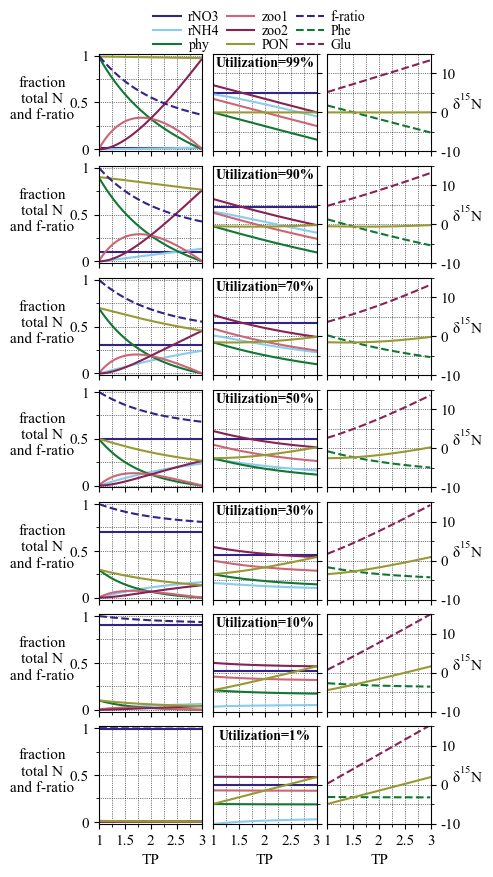

In [7]:
# plot TP vs fraction of each model component


TP_array=np.arange(1.01,3,.01)

# set colors for plotting
# from Paul Tol's colorblind friendly
# muted palette:
# https://personal.sron.nl/~pault/

color_dict={'phy':'#117733','zoo1':'#CC6677','zoo2':'#882255',
            'rNO3':'#332288','rNH4':'#88CCEE','PON':'#999933'}

#select fontsize to use
fs=11

# prepare to loop over range of utilization values
ut_list=[.99,.9,.7,.5,.3,.1,.01]
row=0

# initialize plot
fig,axs=plt.subplots(len(ut_list),3,sharex='all')
plt.subplots_adjust(wspace=0.1,hspace=0.15)

# loop over utilization rates selected in ut_list, run
# model and plot results
for i in ut_list:
    # run model
    results_dict=d15N_model(TP=TP_array,            # desired trophic position or array of trophic positions
                            eps_assim1=5.0,    # d15N fractionation during phyto NO3 uptake
                            eps_assim2=10.0,    # d15N fractionation during phyto NH4 uptake
                            bulk_TEF=3.5,         # d15N fractionation during zooplankton NH4 excretion
                            p_exc=0.4,         # proportion of zooplankton diet excreted (as NH4)
                            d_sNO3=0,          # d15N of source NO3 supplied to euphotic zone
                            p_NO3=i,          # fraction of NO3 utilized by phytoplankton
                            p_NH4=i,         # NH4 utilization proportion
                            beta_bulkphe=-1.8, # d15N bulk minus d15N Phe in phytoplankton
                            beta_gluphe=3.4,   # d15N Glu minus d15N Phe in phytoplankton
                            TDF_Glu=7.6,       # d15N trophic discrimination factor of Glu relative to Phe per trophic transfer 
                            TEF_Phe=0.0,       # d15N trophic enrichment of Phe per trophic transfer 
                            NO3_model='open',  # NO3 uptake fractionation model. options are 'open' or 'rayleigh'
                            NH4_model='open')  # NH4 uptake fractionation model. options are 'open' or 'rayleigh'
    results = SimpleNamespace(**results_dict)
    
    # share y axis between middle and right subplots
    axs[row,1].sharey(axs[row,2])

    # plot model results

    for j in ['rNO3','rNH4','phy','zoo1','zoo2','PON']:
        # plot fractions and f-ratio results in left column
        axs[row,0].plot(TP_array,results_dict[f'f_{j}'],color=color_dict[j],label=j)

        #plot d15N of each N pool in middle column
        axs[row,1].plot(TP_array,results_dict[f'd_{j}'],color=color_dict[j])
    
    axs[row,0].plot(TP_array,results.f_ratio,color=color_dict['rNO3'],linestyle='--',label='f-ratio')
    #plot d15N bulk, Glu and Phe in right column
    axs[row,2].plot(TP_array,results.d_phe,color=color_dict['phy'], linestyle='--',label='Phe')
    axs[row,2].plot(TP_array,results.d_glu,color=color_dict['zoo2'],linestyle='--',label='Glu')
    axs[row,2].plot(TP_array,results.d_PON,color=color_dict['PON'],linestyle='-')

    # configure misc plot properties
    for ax in [axs[row,0],axs[row,1],axs[row,2]]:
        ax.grid(linestyle=':',lw=.5,color='k',which='both')
        ax.set_xlim(1,3)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
        ax.xaxis.set_major_locator(mticker.MultipleLocator(base=.5))
        ax.tick_params(labelsize=fs)
        if row == len(ut_list)-1:
            ax.set_xlabel('TP',fontsize=fs)
            
    axs[row,0].xaxis.set_major_locator(mticker.MultipleLocator(base=.5))
    axs[row,0].xaxis.set_minor_locator(mticker.MultipleLocator(base=.25))

    axs[row,0].yaxis.set_major_locator(mticker.MultipleLocator(base=.5))
    axs[row,0].yaxis.set_minor_locator(mticker.MultipleLocator(base=.25))
    axs[row,1].yaxis.set_major_locator(mticker.MultipleLocator(base=10))
    axs[row,1].yaxis.set_minor_locator(mticker.MultipleLocator(base=5))
    
    axs[row,0].set_ylabel('fraction\ntotal N\nand f-ratio',rotation=0,labelpad=20,y=.3,fontsize=fs)
    axs[row,2].set_ylabel('$\mathdefault{δ^{15}N}$',rotation=0, labelpad=5,y=.6,fontsize=fs)

    axs[row,0].set_ylim(-0.02,1.02)
    axs[row,1].set_ylim(-10,15) 

    axs[row,1].tick_params(axis='y', which='both',
                       labelleft=False,labelright=False,
                       right=True,left=False)
    
    axs[row,2].yaxis.set_label_position("right")
    axs[row,2].yaxis.tick_right()

    axs[row,1].set_title('Utilization='+str(round((i)*100))+'%',fontsize=fs-1,
                        loc='center',y=.78,x=.5,weight='semibold',zorder=0,
                        bbox=dict(facecolor='w',alpha=.7,edgecolor='None', pad=0))
    
    # axs[row,1].text('Utilization='+str(round((1-i)*100))+'%',x=.15,ha='left')
    if row == 0:
        fig.legend(fontsize=fs-1,ncols=3,columnspacing=.5,borderpad=0,
                   labelspacing=0,handletextpad=.5,frameon=False,
                   loc='lower center',bbox_to_anchor=(.5,.875))
    row=row+1
fig.set_size_inches(10/row*3,10)
plt.savefig('Figures/FigS1.png',bbox_inches='tight', dpi=1000)
plt.savefig('Figures/FigS1.pdf',bbox_inches='tight', dpi=1000)
plt.show()
plt.close()

### **Figure 2** Plot model predicted relationships between TP and δ<sup>15</sup>N<sub>Phe</sub> (left), plus TP and δ<sup>15</sup>N<sub>bulk</sub> (right) in a range of nutrient utilization scenarios

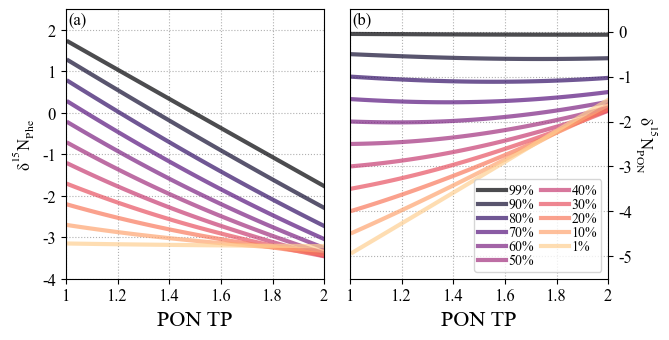

In [8]:
'''
define range of TP, p_NH4 (ammonium utilization) 
to loop over for sensitivity analysis
'''
TP_array=np.arange(1.01,2.01,.01)
p_NH4_array=np.flip(np.array([.01,.10,.20,.30,.40,.50,.60,.70,.80,.90,.99]))
colors=matplotlib.colormaps['magma'](np.linspace(0, .9, len(p_NH4_array)))

'''initialize plot'''
fig,axs=plt.subplots(1,2,figsize=(full_width,half_width),sharex='all')
plt.subplots_adjust(wspace=.1)

'''
loop over possible parameters for the extent of nutrient utilization, 
plotting the results together
'''
for i in np.arange(0,len(p_NH4_array),1):
    #run mass-balance model
    p_NH4=p_NH4_array[i]
    p_NO3=p_NH4
    results_dict=d15N_model(TP=TP_array,            # desired trophic position
                            eps_assim1=5,      # d15N fractionation during phyto NO3 uptake
                            eps_assim2=10,     # d15N fractionation during phyto NH4 uptake
                            bulk_TEF=3.5,
                            p_exc=0.4,         # proportion of zooplankton diet excreted (as NH4)
                            d_sNO3=0,          # d15N of source NO3 supplied to euphotic zone
                            p_NO3=p_NO3,     # fraction of NO3 that goes unutilized by phytoplankton
                            p_NH4=p_NH4,       # NH4 utilization proportion
                            beta_bulkphe=-1.8, # d15N bulk minus d15N Phe in phytoplankton
                            beta_gluphe=3.4,   # d15N Glu minus d15N Phe in phytoplankton
                            TDF_Glu=7.6,       # d15N trophic discrimination factor of Glu relative to Phe per trophic transfer 
                            TEF_Phe=0.0,       # d15N trophic enrichment of Phe per trophic transfer 
                            NO3_model='open',  # NO3 uptake fractionation model. options are 'open' or 'rayleigh'
                            NH4_model='open')  # NH4 uptake fractionation model. options are 'open' or 'rayleigh'
    results = SimpleNamespace(**results_dict)
    
    #plot results
    axs[0].plot(TP_array,results.d_phe,color=colors[i],label=str(round(p_NH4*100))+'%',linewidth=3,alpha=.7)
    axs[1].plot(TP_array,results.d_PON,color=colors[i],label=str(round(p_NH4*100))+'%',linewidth=3,alpha=.7)

''' format axes, labels, ticks '''
for ax in [0,1]:   
    axs[ax].set_xlabel('PON TP',fontsize=16)
    axs[ax].tick_params(axis='both', which='major')
    axs[ax].grid(axis='both', linestyle=':')
    axs[ax].yaxis.set_major_formatter(FormatStrFormatter('%g'))

axs[0].set_xlim(1,2)
axs[0].xaxis.set_major_formatter(FormatStrFormatter('%g'))

axs[0].set_ylim(-4,2.5)
axs[1].set_ylim(-5.5,.5)

axs[0].set_ylabel('$\mathregular{δ^{15}N_{Phe}}$')
axs[1].set_ylabel('$\mathregular{δ^{15}N_{PON}}$',rotation=270,labelpad=20)

axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()

axs[1].legend(facecolor='w',fontsize=10,ncol=2,
               columnspacing=.5,borderpad=0.3,
               labelspacing=0,handletextpad=.2)

''' add subplot labels '''
text=axs[0].text(0.01,0.99,'(a)',ha='left',va='top',transform=axs[0].transAxes,
            bbox=dict(boxstyle='square,pad=0',alpha=.5, fc='w', ec='none'))
text=axs[1].text(0.01,0.99,'(b)',ha='left',va='top',transform=axs[1].transAxes,
            bbox=dict(boxstyle='square,pad=0',alpha=.5, fc='w', ec='none'))

# plt.savefig('Figures/fig3.png',bbox_inches='tight', dpi=1000)
plt.show()
plt.close()

### Figure 2 alternative version with f-ratio

ut= 0.999 change d_phe= 3.5 change d_phy= 3.5 change d_PON= 0.0 change f-ratio= 0.99  to  0.55
ut= 0.9 change d_phe= 3.59 change d_phy= 3.59 change d_PON= 0.09 change f-ratio= 0.99  to  0.59
ut= 0.8 change d_phe= 3.52 change d_phy= 3.52 change d_PON= 0.02 change f-ratio= 0.99  to  0.64
ut= 0.7 change d_phe= 3.33 change d_phy= 3.33 change d_PON= -0.17 change f-ratio= 1.0  to  0.68
ut= 0.6 change d_phe= 3.05 change d_phy= 3.05 change d_PON= -0.45 change f-ratio= 1.0  to  0.73
ut= 0.5 change d_phe= 2.68 change d_phy= 2.68 change d_PON= -0.82 change f-ratio= 1.0  to  0.77
ut= 0.45 change d_phe= 2.47 change d_phy= 2.47 change d_PON= -1.03 change f-ratio= 1.0  to  0.8
ut= 0.4 change d_phe= 2.24 change d_phy= 2.24 change d_PON= -1.26 change f-ratio= 1.0  to  0.82
ut= 0.3 change d_phe= 1.75 change d_phy= 1.75 change d_PON= -1.75 change f-ratio= 1.0  to  0.86
ut= 0.2 change d_phe= 1.2 change d_phy= 1.2 change d_PON= -2.3 change f-ratio= 1.0  to  0.91
ut= 0.1 change d_phe= 0.62 change d_phy= 0.6

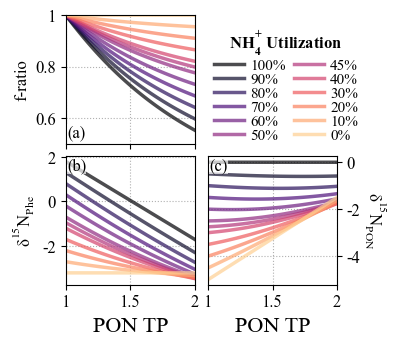

In [9]:
'''
define range of TP, p_NH4 (ammonium utilization) 
to loop over for sensitivity analysis
'''
TP_array=np.arange(1.01,2.02,.01)
p_NH4_array=np.flip(np.array([0.0001,.10,.20,.30,.40,.45,.50,.60,.70,.80,.90,.999]))
colors=matplotlib.colormaps['magma'](np.linspace(0, .9, len(p_NH4_array)))

'''initialize plot'''
fig,axs=plt.subplots(2,2,figsize=(half_width,half_width),sharex='all')
plt.subplots_adjust(wspace=.1,hspace=.1)

'''
loop over possible parameters for the extent of nutrient utilization, 
plotting the results together
'''
for i in np.arange(0,len(p_NH4_array),1):
    #run mass-balance model
    p_NH4=p_NH4_array[i]
    p_NO3=p_NH4
    results_dict=d15N_model(TP=TP_array,            # desired trophic position
                            eps_assim1=5,      # d15N fractionation during phyto NO3 uptake
                            eps_assim2=10,     # d15N fractionation during phyto NH4 uptake
                            bulk_TEF=3.5,
                            p_exc=0.4,         # proportion of zooplankton diet excreted (as NH4)
                            d_sNO3=0,          # d15N of source NO3 supplied to euphotic zone
                            p_NO3=p_NO3,     # fraction of NO3 that goes unutilized by phytoplankton
                            p_NH4=p_NH4,       # NH4 utilization proportion
                            beta_bulkphe=-1.8, # d15N bulk minus d15N Phe in phytoplankton
                            beta_gluphe=3.4,   # d15N Glu minus d15N Phe in phytoplankton
                            TDF_Glu=7.6,       # d15N trophic discrimination factor of Glu relative to Phe per trophic transfer 
                            TEF_Phe=0.0,       # d15N trophic enrichment of Phe per trophic transfer 
                            NO3_model='open',  # NO3 uptake fractionation model. options are 'open' or 'rayleigh'
                            NH4_model='open')  # NH4 uptake fractionation model. options are 'open' or 'rayleigh'
    results = SimpleNamespace(**results_dict)
    print('ut=',p_NH4,'change d_phe=',round(results.d_phe[0]-results.d_phe[-1],2),
          'change d_phy=',round(results.d_phy[0]-results.d_phy[-1],2),
          'change d_PON=',round(results.d_PON[0]-results.d_PON[-1],2),
          'change f-ratio=',round(results.f_ratio[0],2), ' to ', round(results.f_ratio[-1],2))
    #plot results
    axs[1,0].plot(TP_array,results.d_phe,color=colors[i],label=str(round(p_NH4*100))+'%',lw=2.5,alpha=.7)
    axs[1,1].plot(TP_array,results.d_PON,color=colors[i],lw=2.5,alpha=.7)
    axs[0,0].plot(TP_array,results.f_ratio,color=colors[i],lw=2.5,alpha=.7)

''' format axes, labels, ticks '''
axs[0,1].remove()

for ax in [0,1]:   
    axs[1,ax].set_xlabel('PON TP',fontsize=16)
    for i in [0,1]:
        axs[i,ax].tick_params(axis='both', which='major')
        axs[i,ax].grid(axis='both', linestyle=':')
        axs[i,ax].yaxis.set_major_formatter(FormatStrFormatter('%g'))

axs[0,0].set_xlim(1,2)
axs[0,0].set_ylim(.5,1)
axs[0,0].xaxis.set_major_formatter(FormatStrFormatter('%g'))

# axs[1,0].set_ylim(-3.5,2.5)
# axs[1,1].set_ylim(-5.5,.5)

axs[1,0].set_ylabel('$\mathregular{δ^{15}N_{Phe}}$')
axs[1,1].set_ylabel('$\mathregular{δ^{15}N_{PON}}$',rotation=270,labelpad=20)
axs[0,0].set_ylabel('f-ratio')

axs[1,1].yaxis.set_label_position("right")
axs[1,1].yaxis.tick_right()

legend=axs[1,0].legend(facecolor='w',fontsize=11,ncol=2,
              columnspacing=.5,borderpad=0.3,
              labelspacing=0,handletextpad=.4,
              frameon=False,
              loc='upper left',bbox_to_anchor=(1.05,2.1),
              title_fontproperties={'weight':'semibold'})
legend.set_title('$\mathregular{NH_{4}^{+}}$ Utilization')

''' add subplot labels '''
text=axs[0,0].text(0.01,0.15,'(a)',ha='left',va='top',transform=axs[0,0].transAxes,
            bbox=dict(boxstyle='square,pad=0',alpha=.7, fc='w', ec='none'))
text=axs[1,0].text(0.01,0.99,'(b)',ha='left',va='top',transform=axs[1,0].transAxes,
            bbox=dict(boxstyle='square,pad=0',alpha=.7, fc='w', ec='none'))
text=axs[1,1].text(0.01,0.99,'(c)',ha='left',va='top',transform=axs[1,1].transAxes,
            bbox=dict(boxstyle='square,pad=0',alpha=.7, fc='w', ec='none'))

plt.savefig('Figures/Fig3.png',bbox_inches='tight', dpi=1000)
plt.savefig('Figures/Fig3.pdf',bbox_inches='tight', dpi=1000)
plt.show()
plt.close()

# --------------------------------------------------------------------------------------

# **3. Analysis of compiled deep-sea coral and sediment core paleoceanographic datasets**

# **What relationships between TP and δ<sup>15</sup>N<sub>Phe</sub> do we see in actual paleoceanographic records? And are they statistically significant?**

## **Section 3.1**

## Here we load and process ten paleoceanographic amino acid δ<sup>15</sup>N datasets and calculate the observed correlation and regression slope between TP and δ<sup>15</sup>N<sub>Phe</sub>. 

### First, we calculate TP, lag-1 autocorrelation coefficient, other descriptive statistics, and the linear regression slope and spearman's rho correlation coefficient between TP and δ<sup>15</sup>N<sub>Phe</sub>. Then we load this info into one summary dataframe.

In [10]:
#Load Actual d15N datasets, process and summarize them

# intialize nested dictionary
obs_dict = { 'SR':   {'abbrev': 'SR', 'xl_sheet': 'Pugsley_SR', 'coral': True,
                      'lat': 36.4, 'lon': -122.3, 'depth':1250, 'stp_mult':.9},
             'PI':   {'abbrev': 'PI', 'xl_sheet': 'Shen_Pioneer', 'coral': True,
                      'lat': 37.359, 'lon': -123.394, 'depth':1300, 'stp_mult':.9},
             'MC':   {'abbrev': 'MC', 'xl_sheet': 'Shen_MontereyCanyon', 'coral': True,
                      'lat': 36.744, 'lon': -122.037, 'depth':870, 'stp_mult':.9},
             'NPSG': {'abbrev': 'NPSG', 'xl_sheet': 'Sherwood_gold', 'coral': True,
                      'lat': 21.29, 'lon': -157.54, 'depth':450, 'stp_mult':.9},
             'KR':   {'abbrev': 'KR', 'xl_sheet': 'Glynn_equatorial', 'coral': True,
                      'lat': 6.38, 'lon': -162.42, 'depth':400, 'stp_mult':.9},
             'ET':   {'abbrev': 'ET', 'xl_sheet': 'Strzepek_ETas', 'coral': True,
                      'lat': -42.5, 'lon': 149.25, 'depth':1200, 'stp_mult':1},
             'SWT':  {'abbrev': 'SWT', 'xl_sheet': 'Strzepek_SWTas', 'coral': True,
                      'lat': -45.3, 'lon': 145.35, 'depth':2400, 'stp_mult':1.2},
             'LHR':  {'abbrev': 'LHR', 'xl_sheet': 'Strzepek_LHR', 'coral': True,
                      'lat': -27.85, 'lon': 161.85, 'depth':1550, 'stp_mult':1.2},
             'BS':   {'abbrev': 'BS', 'xl_sheet': 'Delong_Bering', 'coral': False,
                      'lat': 53.4, 'lon': -179.52, 'depth': 1300, 'stp_mult': 1.1},
             'SBB':  {'abbrev': 'SBB', 'xl_sheet': 'Batista_SBB', 'coral': False,
                      'lat': 34.23, 'lon': -120.03, 'depth':450, 'stp_mult':.8},
           }

# loop through each dataset in our compilation
for i in [obs_dict[k]['abbrev'] for k in obs_dict]:

    #read in dataset from excel
    df_dataset=pd.read_excel(r'Datasets/TP_Phe comparison.xlsx',obs_dict[i]['xl_sheet'])

    # drop one very low unrealistic TP value (<0.5) 
    # from Batista et al. Santa Barbara Basin dataset
    TP_check=TP(df_dataset['Glu'],df_dataset['Phe'],coral=obs_dict[i]['coral'])
    df_dataset=df_dataset.where(TP_check>0.9).dropna()

    #calculate TP
    TP_obs=TP(df_dataset['Glu'],df_dataset['Phe'],coral=obs_dict[i]['coral'])

    # for a few sites we don't have an age model
    # so am using sample id instead to estimate lag-1 autocorrelation
    # assuming a constant growth or accumulation rate
    if obs_dict[i]['abbrev'] in ['PI','MC','SBB']:
        age_sel=df_dataset['Sample']
    else:
        age_sel=df_dataset['age']

    # create new dataframe with variables of interest from this specific dataset
    sorted_dataframe=pd.DataFrame({'age':age_sel,'Glu':df_dataset['Glu'],
                                   'Phe':df_dataset['Phe'],'Lys':df_dataset['Lys'],
                                   'TP':TP_obs}).sort_values(by='age')
    obs_dict[i].update(sorted_dataframe.to_dict('list'))

    # calculate the lag-1 autocorrelation coefficient for TP and Phe
    # using lag1ac helper function defined in Section 1
    auto_phe,phe_interp_time,phe_interp=lag1ac(sorted_dataframe['age'],sorted_dataframe['Phe'],step_mult=obs_dict[i]['stp_mult'])
    auto_TP,TP_interp_time,TP_interp=lag1ac(sorted_dataframe['age'],sorted_dataframe['TP'],step_mult=obs_dict[i]['stp_mult'])

    # print lag 1 ac for interpolated vs original timeseries to see what
    # the effect of interpolation is 
    # print(obs_dict[i]['abbrev']+' nointerp phe lag-1 ac',round(smt.acf(sorted_dataframe['Phe'],nlags=1,fft=True)[1],2))
    # print(obs_dict[i]['abbrev']+' interp phe lag-1 ac',round(auto_phe,2))
    # print(obs_dict[i]['abbrev']+' nointerp tp lag-1 ac',round(smt.acf(sorted_dataframe['TP'],nlags=1,fft=True)[1],2))
    # print(obs_dict[i]['abbrev']+' interp tp lag-1 ac',round(auto_TP,2))

    # plot the original vs interpolated time series to see how 
    # well the interpolation reproduces the main patterns in the 
    # data. Want to capture main features without adding too
    # many extra points, which artificially inflates the ac coefficient
    # fig,ax=plt.subplots(figsize=(half_width,half_width))
    # plt.plot(phe_interp_time,phe_interp,color='r',marker='o',label=obs_dict[i]['abbrev']+' interp')
    # plt.plot(sorted_dataframe['age'],sorted_dataframe['Phe'],color='k',marker='^',label=obs_dict[i]['abbrev']+' orig Phe')
    # plt.legend()
    # plt.show()
    # plt.close()
    
    # fig,ax=plt.subplots(figsize=(half_width,half_width))
    # plt.plot(TP_interp_time,TP_interp,color='r',marker='o',label=obs_dict[i]['abbrev']+' interp')
    # plt.plot(sorted_dataframe['age'],sorted_dataframe['TP'],color='k',marker='^',label=obs_dict[i]['abbrev']+' orig TP')
    # plt.legend()
    # plt.show()
    # plt.close()

    # calculate spearman's rho and the slope 
    # of the linear regression
    # between TP and Phe
    # and TP and Glu
    rho_Phe_obs=rho_calc(sorted_dataframe['TP'],
                     sorted_dataframe['Phe'])
    m_Phe_obs=slope_calc(sorted_dataframe['TP'],
                     sorted_dataframe['Phe'])
    rho_Lys_obs=rho_calc(sorted_dataframe['TP'],
                     sorted_dataframe['Lys'])
    m_Lys_obs=slope_calc(sorted_dataframe['TP'],
                     sorted_dataframe['Lys'])
    rho_Glu_obs=rho_calc(sorted_dataframe['TP'],
                     sorted_dataframe['Glu'])
    m_Glu_obs=slope_calc(sorted_dataframe['TP'],
                     sorted_dataframe['Glu'])

    # update dictionary with new stuff we calculated above plus some
    # additional features of the dataset
    obs_dict[i].update({'rho_Phe':np.round(rho_Phe_obs,2),'m_Phe':np.round(m_Phe_obs,1),
                        'rho_Lys':np.round(rho_Lys_obs,2),'m_Lys':np.round(m_Lys_obs,1),
                        'rho_Glu':np.round(rho_Glu_obs,2),'m_Glu':np.round(m_Glu_obs,1),
                        'mean_Phe':np.round(np.mean(sorted_dataframe['Phe']),1),
                        'mean_TP':np.round(np.mean(sorted_dataframe['TP']),1),
                        'range_Phe':np.round(max(sorted_dataframe['Phe'])-
                                             min(sorted_dataframe['Phe']),1),
                        'range_TP':np.round(max(sorted_dataframe['TP'])
                                            -min(sorted_dataframe['TP']),1),
                        'auto_Phe':np.round(auto_phe,2),'auto_TP':np.round(auto_TP,2),
                        'n_obs':len(sorted_dataframe['Phe'])
                       })

# # create new summary dataframe from all the stats we calculated in the loop 
# # above for each dataset
obs_summary=pd.DataFrame({'Abbreviation': [obs_dict[k]['abbrev'] for k in obs_dict],
                          'Coral?': [obs_dict[k]['coral'] for k in obs_dict],
                        'Latitude':np.round([obs_dict[k]['lat'] for k in obs_dict],1),
                        'Longitude':np.round([obs_dict[k]['lon'] for k in obs_dict],1),
                        'Water Depth':[obs_dict[k]['depth'] for k in obs_dict],
                        'rho_Phe': [obs_dict[k]['rho_Phe'] for k in obs_dict],
                        'slope_Phe': [obs_dict[k]['m_Phe'] for k in obs_dict],
                        'rho_Lys': [obs_dict[k]['rho_Lys'] for k in obs_dict],
                        'slope_Lys': [obs_dict[k]['m_Lys'] for k in obs_dict],
                        'rho_Glu': [obs_dict[k]['rho_Glu'] for k in obs_dict],
                        'slope_Glu': [obs_dict[k]['m_Glu'] for k in obs_dict],
                        'Phe mean':[obs_dict[k]['mean_Phe'] for k in obs_dict],
                        'TP mean':[obs_dict[k]['mean_TP'] for k in obs_dict],
                        'Phe range':[obs_dict[k]['range_Phe'] for k in obs_dict],
                        'TP range':[obs_dict[k]['range_TP'] for k in obs_dict],
                        'Phe Lag-1 AC':[obs_dict[k]['auto_Phe'] for k in obs_dict],
                        'TP Lag-1 AC':[obs_dict[k]['auto_TP'] for k in obs_dict],
                        '# Obs':[obs_dict[k]['n_obs'] for k in obs_dict],
                        'TP':[obs_dict[k]['TP'] for k in obs_dict],
                        'Phe':[obs_dict[k]['Phe'] for k in obs_dict],
                        'Glu':[obs_dict[k]['Glu'] for k in obs_dict],
                        'Lys':[obs_dict[k]['Lys'] for k in obs_dict],
                        'age':[obs_dict[k]['age'] for k in obs_dict]
                       })

### View resulting summary dataframe

In [11]:
display(obs_summary)

,Abbreviation,Coral?,Latitude,Longitude,Water Depth,rho_Phe,slope_Phe,rho_Lys,slope_Lys,rho_Glu,...,Phe range,TP range,Phe Lag-1 AC,TP Lag-1 AC,# Obs,TP,Phe,Glu,Lys,age
0,SR,True,36.4,-122.3,1250,-0.71,-4.4,0.05,-0.0,0.63,...,2.8,0.6,0.14,0.16,28,"[2.646791979949871, 2.4369590643274868, 2.5026...","[9.26295238095238, 10.0868888888888, 9.4458888...","[21.7785714285714, 21.0077777777777, 20.865777...","[12.0649047619047, 11.4857777777777, 11.238111...","[1820.66666666666, 1822.08108108108, 1833.3243..."
1,PI,True,37.4,-123.4,1300,-0.23,-4.1,0.00,-1.3,0.39,...,3.3,0.3,0.10,0.30,21,"[2.5032894736842106, 2.6016447368421045, 2.579...","[8.4113, 8.759800000000002, 9.832666666666666,...","[19.8363, 20.932299999999998, 21.8364166666666...","[10.83235, 10.898349999999999, 12.882833333333...","[1, 3, 4, 5, 6, 8, 11, 14, 15, 16, 18, 19, 20,..."
2,MC,True,36.7,-122.0,870,-0.68,-6.5,-0.14,-0.7,0.23,...,5.1,0.4,0.15,0.06,21,"[2.506710526315789, 2.3958114035087714, 2.5796...","[8.256, 9.720666666666668, 8.124791666666667, ...","[19.707, 20.328833333333332, 20.12983333333333...","[10.53, 10.751000000000001, 10.711125, 10.987,...","[1, 2, 5, 8, 11, 13, 14, 15, 17, 18, 20, 21, 2..."
3,NPSG,True,21.3,-157.5,450,-0.22,-1.1,-0.05,-0.7,0.80,...,2.4,0.6,0.58,-0.03,20,"[3.1315789473684212, 3.5, 3.486842105263158, 3...","[4.3, 4.3, 4.0, 4.5, 4.2, 4.4, 4.4, 3.4, 4.0, ...","[20.5, 23.3, 22.9, 20.7, 24.0, 22.5, 22.5, 22....","[6.6, 6.5, 7.0, 6.5, 6.6, 6.5, 6.6, 6.0, 5.7, ...","[1224, 1311, 1315, 1352, 1373, 1452, 1462, 150..."
4,KR,True,6.4,-162.4,400,-0.73,-6.9,-0.43,-2.5,0.00,...,4.1,0.4,0.22,0.44,9,"[3.552631578947368, 3.8947368421052633, 3.9342...","[10.1, 7.4, 7.8, 7.6, 7.4, 7.0, 9.0, 11.1, 8.5]","[29.5, 29.4, 30.1, 29.7, 29.9, 28.9, 30.2, 30....","[12.6, 11.5, 11.2, 10.5, 11.2, 12.2, 9.8, 12.9...","[171, 426, 551, 704, 1276, 1400, 1636, 1813, 1..."
5,ET,True,-42.5,149.2,1200,-0.80,-4.9,0.45,0.7,0.30,...,5.5,0.8,0.20,0.03,10,"[2.864473684210526, 3.310526315789474, 2.77763...","[3.41, 2.17, 4.06, 3.5, 4.15, 7.7, 3.72, 4.94,...","[17.58, 19.73, 17.57, 19.39, 16.87, 20.28, 20....","[6.87, 7.48, 7.68, 7.47, 6.79, 7.2, 7.47, 8.07...","[1940, 1961, 1970, 1970, 1975, 1980, 1988, 199..."
6,SWT,True,-45.3,145.4,2400,-0.85,-7.3,-0.45,-4.6,-0.04,...,4.3,0.6,-0.35,-0.33,20,"[2.4039473684210524, 2.3671052631578946, 2.115...","[0.5, 3.11, 2.57, 1.24, 3.87, 1.92, 0.97, 3.35...","[11.17, 13.5, 11.05, 12.1, 11.91, 12.38, 11.92...","[4.66, 6.27, 6.79, 2.39, 6.07, 5.32, 2.81, 2.8...","[1900, 1913, 1921, 1922, 1931, 1939, 1946, 194..."
7,LHR,True,-27.8,161.8,1550,-0.80,-5.6,-0.51,-2.3,0.72,...,6.8,1.0,0.37,0.49,25,"[2.863157894736842, 2.8921052631578945, 2.8552...","[4.69, 4.18, 3.18, 4.13, 4.14, 2.3, 2.72, 4.77...","[18.85, 18.56, 17.28, 16.91, 16.91, 19.42, 17....","[5.08, 5.47, 7.8, 9.77, 6.11, 2.79, 6.0, 8.09,...","[1888, 1893, 1895, 1906, 1916, 1924, 1925, 193..."
8,BS,False,53.4,-179.5,1300,-0.52,-3.8,-0.47,-4.3,0.48,...,5.3,0.7,0.77,0.40,29,"[1.561998746867168, 1.4705263157894737, 1.8904...","[6.853809523809524, 6.422833333333332, 6.56685...","[14.525000000000002, 13.398833333333332, 16.73...","[4.106428571428571, 5.545166666666667, 4.37438...","[6212.300884955752, 7513.185840707964, 9594.60..."
9,SBB,False,34.2,-120.0,450,-0.44,-2.6,-0.11,-0.7,0.76,...,4.3,0.6,0.25,0.24,12,"[0.9736842105263157, 1.0921052631578947, 1.315...","[10.0, 10.5, 10.4, 10.1, 12.4, 9.3, 9.3, 8.1, ...","[13.2, 14.6, 16.2, 13.7, 17.6, 16.9, 15.9, 15....","[8.1, 9.3, 8.0, 8.0, 10.2, 9.2, 9.5, 7.5, 11.3...","[0.0, 1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 16.0, 22...."



## **Section 3.2** 

## **Spurious Correlations Analysis:** We find strong negative relationships between TP and δ<sup>15</sup>N<sub>Phe</sub> in the paleoceanographic records. But could the relationships we see be spurious/a statistical artifact? TP is calculated from δ<sup>15</sup>N<sub>Phe</sub> and δ<sup>15</sup>N<sub>Glu</sub>, so TP and δ<sup>15</sup>N<sub>Phe</sub> are inherently non-independent. Therefore, we cannot determine the statistical significance of these relationships using conventional approaches that assume independence of variables. 

## Instead, we will perform a series of ***Monte Carlo simulations based on compound-specific nitrogen isotope ecology theory***. In these simulations, we randomly generate timeseries datasets of TP and δ<sup>15</sup>N<sub>Phe</sub> measurements, incorporating known sources of uncertainty (including analytical error and uncertainty in parameters like the TEF of Glu and Phe, and β), plus other factors like autocorrelation and the range of TP and baseline δ<sup>15</sup>N that may influence the strength of relationships between TP and δ<sup>15</sup>N<sub>Phe</sub>. See where the TP_Phe_simulation helper function is defined above in Section 1 to view the relevant code and step-by-step explanations of our approach.

## **Note:** In these Monte Carlo simulations, the ***true*** values of TP and δ<sup>15</sup>N baseline are ***completely independent***. So any simulated relationship between ***measured*** TP and δ<sup>15</sup>N<sub>Phe</sub> is spurious and happens due to non-independence of TP and δ<sup>15</sup>N<sub>Phe</sub> or some other important factor such as timeseries autocorrelation. This approach allows us to perform robust significance testing by taking into account expected spurious correlations due to these factors, and determining meaningful significance thresholds numerically.

### Set default parameters for simulations

In [12]:
# default parameters

# length of simulated timeseries
n_def=int(np.round(np.mean(obs_summary['# Obs'])))

# number of simulated timeseries
nsims_def=10000  

# calculate correlations with spearman or pearson?
corrtest_def='spearman'        

# distribution for simulating uncertainties
uncertainty_dist_def='normal'   

# ranges for TP and baseline timeseries
TP_range_def=[2.2,2.2+np.mean(obs_summary['TP range'])]          
baseline_range_def=[-np.mean(obs_summary['Phe range'])/2,
                    np.mean(obs_summary['Phe range'])/2]    

# TEF values and uncertainties for Glu and Phe
# TEF values from Chikaraishi et al., 2009
Phe_TEF_def=0.4
Glu_TEF_def=8.0
Phe_TEF_std_def=0 #Chikaraishi value=0.5
Glu_TEF_std_def=0 #Chikaraishi value=1.2

# lag-1 autocorrelation coefficients
# for simulated TP and d15N Phe timeseries
lag1ac_TP_def=np.mean(obs_summary['TP Lag-1 AC'])
lag1ac_baseline_def=np.mean(obs_summary['Phe Lag-1 AC'])

# Uncertainty from repeated triplicate measurements
# of long-term McCarthy lab cyanobacteria standard 
# over 5 years (Christensen et al., 2023)
Glu_meas_std_def=0.7  # Christensen et al.,2023 value=0.6
Phe_meas_std_def=0.7  # Christensen et al.,2023 value=0.7
                            
# nonvascular autotroph beta and uncertainty
# from Ramirez et al. 2021
beta_def=3.4
beta_std_def=0 #Ramirez et al. 2021 value=1.8

# correction for polyp-skeleton offset, 
# in Coral TP estimation
# from McMahon et al. 2018
d_def=3.4
d_std_def=0 #McMahon et al 2018 value=0.1   

# should d15N baseline vary through time?
baseline_variability_def=True

# is the simualtion for a coral?
# if so will account for d uncertainty
# and calculate TP using coral-specific equation
coral_def=True

### Simulate n=10,000 TP and δ<sup>15</sup>N<sub>Phe</sub> timeseries with lengths equal to the mean number of observations in the paleoceanographic datasets in our analysis. This way, we can get an idea of the expected distribution of correlation coefficients and regression slopes between TP and δ<sup>15</sup>N<sub>Phe</sub>.

### This is a realistic but fairly conservative simulation (uses defaults derived in cell above-mostly based on mean values abserved in the paleoceanographic dataset compilation). In the interest of being conservative for significance testing, we elected to neglect uncertainty in the TEFs for Glu and Phe, d and β, because larger uncertainties in these parameters actually *decrease* the probability of obtaining spurious correlations and regression coefficients between TP and δ<sup>15</sup>N<sub>Phe</sub>.

In [13]:

"""
Simulate n=10,000 measured TP and Phe time series
based on CSI-AA ecology expectations
"""
Phe_sims,Glu_sims,TP_sims,rho_Phe_sims,slope_Phe_sims,rho_Glu_sims,slope_Glu_sims=TP_Phe_simulation(n=n_def,
                                                                       nsims=10000,
                                                                       corrtest=corrtest_def,
                                                                       uncertainty_dist=uncertainty_dist_def,
                                                                       TP_range=TP_range_def,
                                                                       baseline_range=baseline_range_def,
                                                                       Phe_TEF=Phe_TEF_def, 
                                                                       Glu_TEF=Glu_TEF_def,
                                                                       Phe_TEF_std=Phe_TEF_std_def,
                                                                       Glu_TEF_std=Glu_TEF_std_def,
                                                                       lag1ac_TP=lag1ac_TP_def,
                                                                       lag1ac_baseline=lag1ac_baseline_def,
                                                                       Glu_meas_std=Glu_meas_std_def,
                                                                       Phe_meas_std=Phe_meas_std_def,
                                                                       beta=beta_def, 
                                                                       beta_std=beta_std_def,
                                                                       d=d_def,
                                                                       d_std=d_std_def,   
                                                                       baseline_variability=baseline_variability_def,
                                                                       coral=coral_def)

# uncomment code snippet below if want to calculate p-value for 
# a slope or correlation coefficient based on probability distribution 
# from simulations above
#------------------------------------------------------------------------
#Alternate correlation p-value based on 10,000 simulations
#p_adjusted=scipy.stats.percentileofscore(rho_sims, rho_actual)/100

#Alternate slope p-value based on 10,000 simulations
#p_adjusted=scipy.stats.percentileofscore(slope_sims, slope_actual)/100
#------------------------------------------------------------------------

"""
Find critical rho and slope values from 
probability distribution of simulations
"""
#find critical rho value based on simulations
crit_rho_Phe_5perc=scipy.stats.scoreatpercentile(rho_Phe_sims, 5)
crit_rho_Phe_95perc=scipy.stats.scoreatpercentile(rho_Phe_sims, 95)
crit_rho_Phe_twotail_lower=scipy.stats.scoreatpercentile(rho_Phe_sims, 2.5)
crit_rho_Phe_twotail_upper=scipy.stats.scoreatpercentile(rho_Phe_sims, 97.5)
median_Phe_rho=scipy.stats.scoreatpercentile(rho_Phe_sims, 50)

crit_rho_Glu_5perc=scipy.stats.scoreatpercentile(rho_Glu_sims, 5)
crit_rho_Glu_95perc=scipy.stats.scoreatpercentile(rho_Glu_sims, 95)
crit_rho_Glu_twotail_lower=scipy.stats.scoreatpercentile(rho_Glu_sims, 2.5)
crit_rho_Glu_twotail_upper=scipy.stats.scoreatpercentile(rho_Glu_sims, 97.5)
median_Glu_rho=scipy.stats.scoreatpercentile(rho_Glu_sims, 50)

# print correlation predictions from simulations
print('TP Phe simulated rho median (90% CI)=',median_Phe_rho,'(',crit_rho_Phe_5perc,'to',crit_rho_Phe_95perc,')')
print('TP Glu simulated rho median (90% CI)=',median_Glu_rho,'(',crit_rho_Glu_5perc,'to',crit_rho_Glu_95perc,')')

#find critical rho values based on simulations
crit_slope_Phe_5perc=scipy.stats.scoreatpercentile(slope_Phe_sims, 5)
crit_slope_Phe_95perc=scipy.stats.scoreatpercentile(slope_Phe_sims, 95)
crit_slope_Phe_twotail_lower=scipy.stats.scoreatpercentile(slope_Phe_sims, 2.5)
crit_slope_Phe_twotail_upper=scipy.stats.scoreatpercentile(slope_Phe_sims, 97.5)
median_Phe_slope=scipy.stats.scoreatpercentile(slope_Phe_sims, 50)

crit_slope_Glu_5perc=scipy.stats.scoreatpercentile(slope_Glu_sims, 5)
crit_slope_Glu_95perc=scipy.stats.scoreatpercentile(slope_Glu_sims, 95)
crit_slope_Glu_twotail_lower=scipy.stats.scoreatpercentile(slope_Glu_sims, 2.5)
crit_slope_Glu_twotail_upper=scipy.stats.scoreatpercentile(slope_Glu_sims, 97.5)
median_Glu_slope=scipy.stats.scoreatpercentile(slope_Glu_sims, 50)

# print correlation predictions from simulations
print('TP Phe simulated slope median (90% CI)=',median_Phe_slope,'(',crit_slope_Phe_5perc,'to',crit_slope_Phe_95perc,')')
print('TP Glu simulated slope median (90% CI)=',median_Glu_slope,'(',crit_slope_Glu_5perc,'to',crit_slope_Glu_95perc,')')

# Calculate p-values for observed slopes and regression values based on these simulations
obs_summary['rho_Phe_pval_onetail']=scipy.stats.percentileofscore(rho_Phe_sims,obs_summary['rho_Phe'])/100
obs_summary['rho_Phe_pval_twotail']=scipy.stats.percentileofscore(rho_Phe_sims,obs_summary['rho_Phe'])*2/100

obs_summary['slope_Phe_pval_onetail']=scipy.stats.percentileofscore(slope_Phe_sims,obs_summary['slope_Phe'])/100
obs_summary['slope_Phe_pval_twotail']=scipy.stats.percentileofscore(slope_Phe_sims,obs_summary['slope_Phe'])*2/100

obs_summary['rho_Glu_pval_onetail']=scipy.stats.percentileofscore(rho_Glu_sims,obs_summary['rho_Glu'])/100
obs_summary['rho_Glu_pval_twotail']=scipy.stats.percentileofscore(rho_Glu_sims,obs_summary['rho_Glu'])*2/100

obs_summary['slope_Glu_pval_onetail']=scipy.stats.percentileofscore(slope_Glu_sims,obs_summary['slope_Glu'])/100
obs_summary['slope_Glu_pval_twotail']=scipy.stats.percentileofscore(slope_Glu_sims,obs_summary['slope_Glu'])*2/100

#save significance testing results to table (Table 2 in manuscript)
sigtest_df=obs_summary[['Abbreviation','slope_Phe','slope_Phe_pval_onetail','rho_Phe','rho_Phe_pval_onetail',
                      'slope_Glu','slope_Glu_pval_onetail','rho_Glu','rho_Glu_pval_onetail']]
sigtest_df.to_csv(r'slope_correlations_table2.csv')
display(sigtest_df.round(decimals=3))

TP Phe simulated rho median (90% CI)= -0.12481203007518797 ( -0.49022556390977434 to 0.2646616541353383 )
TP Glu simulated rho median (90% CI)= 0.6947368421052631 ( 0.45563909774436084 to 0.8436090225563909 )
TP Phe simulated slope median (90% CI)= -0.9429456354590484 ( -3.4536519200926574 to 1.6626825680062358 )
TP Glu simulated slope median (90% CI)= 6.657054364540953 ( 4.146348079907344 to 9.262682568006236 )


,Abbreviation,slope_Phe,slope_Phe_pval_onetail,rho_Phe,rho_Phe_pval_onetail,slope_Glu,slope_Glu_pval_onetail,rho_Glu,rho_Glu_pval_onetail
0,SR,-4.4,0.013,-0.71,0.002,3.2,0.013,0.63,0.308
1,PI,-4.1,0.021,-0.23,0.329,3.5,0.021,0.39,0.023
2,MC,-6.5,0.000,-0.68,0.004,1.1,0.000,0.23,0.002
3,NPSG,-1.1,0.460,-0.22,0.344,6.5,0.460,0.80,0.864
4,KR,-6.9,0.000,-0.73,0.001,0.7,0.000,0.00,0.000
5,ET,-4.9,0.005,-0.80,0.000,2.7,0.005,0.30,0.007
6,SWT,-7.3,0.000,-0.85,0.000,0.3,0.000,-0.04,0.000
7,LHR,-5.6,0.001,-0.80,0.000,2.0,0.001,0.72,0.587
8,BS,-3.8,0.031,-0.52,0.036,3.8,0.031,0.48,0.067
9,SBB,-2.6,0.140,-0.44,0.078,5.0,0.140,0.76,0.736


### Plot Figure 4a and 4b visualizing significance testing results

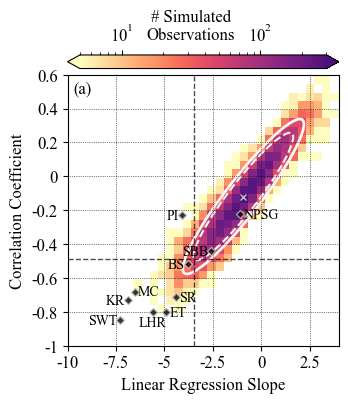

In [14]:
"""
Plot 2d histogram of regression slopes and rho values
from simulations with observed values from paleo datasets
"""
# select colormap
cmap_orig = matplotlib.colormaps['magma_r']
cmap = ListedColormap(cmap_orig(np.linspace(0, 0.75, 200)))

#initialize plot
fig,ax=plt.subplots(figsize=(half_width,4))

# plot 2d histogram of simulated slope and rho values
counts,ybins,xbins,im=ax.hist2d(slope_Phe_sims, rho_Phe_sims, bins=30, density=False,
                                norm=mcolors.LogNorm(vmin=5,vmax=300), 
                                cmin=2,cmap=cmap,zorder=1)

#add x denoting median simulation values
ax.plot(median_Phe_slope,median_Phe_rho,marker='x',
        color='silver',markersize=4,linestyle='None')

# add lines representing significance thresholds
plt.axhline(crit_rho_Phe_5perc,linestyle='--',color='k',lw=1,alpha=.7)
plt.axvline(crit_slope_Phe_5perc,linestyle='--',color='k',lw=1,alpha=.7)

# add 90% and 95% confidence ellipses
confidence_ellipse(np.asarray(slope_Phe_sims), np.asarray(rho_Phe_sims), ax, n_std=1.645,
                   edgecolor='whitesmoke',linestyle='--',lw=1.5,label='90% CI')
confidence_ellipse(np.asarray(slope_Phe_sims), np.asarray(rho_Phe_sims), ax, n_std=2.0,
                   edgecolor='whitesmoke',linestyle='-',lw=2,label='95% CI')

#add colorbar
cb=plt.colorbar(im,extend='both',location='top',
                fraction=.1,pad=0.02)
cb.set_label('# Simulated\nObservations', labelpad=-12,
             fontsize=12,x=.45)

# plot rho and slope values from real coral and sediment datasets
for i in np.arange(0,len(obs_summary.index),1):
    if i == 0:
        ax.plot(obs_summary['slope_Phe'][i],obs_summary['rho_Phe'][i],marker='D',
                markersize=4,color='k',mec='silver',alpha=.8,linestyle='None',
                label='Observations')
    else:
        ax.plot(obs_summary['slope_Phe'][i],obs_summary['rho_Phe'][i],marker='D',
                markersize=4,color='k',mec='silver',alpha=.8,linestyle='None')
    #add labels with each dataset abbreviation
    if obs_summary['Abbreviation'][i] in ['SR','MC','NPSG','ET']:
        ax.text(obs_summary['slope_Phe'][i]+.15,obs_summary['rho_Phe'][i], 
                obs_summary['Abbreviation'][i], ha='left',
                va='center',fontsize=10,rotation=0,color='k')
    elif obs_summary['Abbreviation'][i] in ['LHR']:
        ax.text(obs_summary['slope_Phe'][i],obs_summary['rho_Phe'][i]-.02, 
                obs_summary['Abbreviation'][i], ha='center',
                va='top',fontsize=10,rotation=0,color='k')
    else:
        ax.text(obs_summary['slope_Phe'][i]-.15,obs_summary['rho_Phe'][i], 
                obs_summary['Abbreviation'][i], ha='right',
                va='center',fontsize=10,rotation=0,color='k')  

# set axis labels
plt.xlabel('Linear Regression Slope',fontsize=12)
plt.ylabel('Correlation Coefficient',fontsize=12)

#set axis limits
ax.set_ylim(-1,.6)
ax.set_xlim(-10,4)

# misc axis formatting
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.xaxis.set_major_locator(mticker.MultipleLocator(2.5))

#add gridlines
ax.grid(linestyle=':',color='k',lw=.5,zorder=10)

# add subplot label
text=ax.text(0.02,0.98,'(a)',ha='left',va='top',transform=ax.transAxes,
            bbox=dict(boxstyle='square,pad=0',alpha=.5, fc='w', ec='none'))

#add legend
#plt.legend(loc='upper left',bbox_to_anchor=(0,1),fontsize=10)

#save figure, display and close
plt.savefig('Figures/Fig4a.png',bbox_inches='tight', dpi=1000)
plt.savefig('Figures/Fig4a.pdf',bbox_inches='tight', dpi=1000)
plt.show()
plt.close()

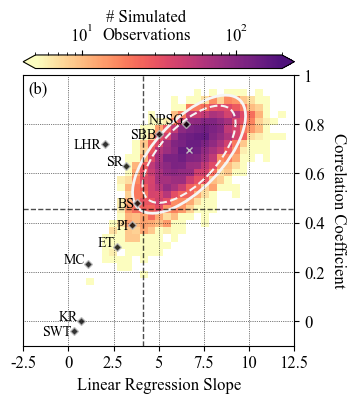

In [15]:
"""
Plot 2d histogram of regression slopes and rho values
from simulations with observed values from paleo datasets
"""
# select colormap
cmap_orig = matplotlib.colormaps['magma_r']
cmap = ListedColormap(cmap_orig(np.linspace(0, 0.75, 200)))

#initialize plot
fig,ax=plt.subplots(figsize=(half_width,4))

# plot 2d histogram of simulated slope and rho values
counts,ybins,xbins,im=ax.hist2d(slope_Glu_sims, rho_Glu_sims, bins=30, density=False,
                                norm=mcolors.LogNorm(vmin=5,vmax=200), 
                                cmin=2,cmap=cmap,zorder=1)

#add x denoting median simulation values
ax.plot(median_Glu_slope,median_Glu_rho,marker='x',
        color='silver',markersize=4,linestyle='None')

# add lines representing significance thresholds
plt.axhline(crit_rho_Glu_5perc,linestyle='--',color='k',lw=1,alpha=.7)
plt.axvline(crit_slope_Glu_5perc,linestyle='--',color='k',lw=1,alpha=.7)

# add 90% and 95% confidence ellipses
confidence_ellipse(np.asarray(slope_Glu_sims), np.asarray(rho_Glu_sims), ax, n_std=1.645,
                   edgecolor='whitesmoke',linestyle='--',lw=1.5,label='90% CI')
confidence_ellipse(np.asarray(slope_Glu_sims), np.asarray(rho_Glu_sims), ax, n_std=2.0,
                   edgecolor='whitesmoke',linestyle='-',lw=2,label='95% CI')

#add colorbar
cb=plt.colorbar(im,extend='both',location='top',
                fraction=.1,pad=0.02)
cb.set_label('# Simulated\nObservations', labelpad=-12,
             fontsize=12,x=.45)

# plot rho and slope values from real coral and sediment datasets
for i in np.arange(0,len(obs_summary.index),1):
    if i == 0:
        ax.plot(obs_summary['slope_Glu'][i],obs_summary['rho_Glu'][i],marker='D',
                markersize=4,color='k',mec='silver',alpha=.8,linestyle='None',
                label='Observations')
    else:
        ax.plot(obs_summary['slope_Glu'][i],obs_summary['rho_Glu'][i],marker='D',
                markersize=4,color='k',mec='silver',alpha=.8,linestyle='None')
    #add labels with each dataset abbreviation
    if obs_summary['Abbreviation'][i] in ['SR','MC','NPSG','ET','KR']:
        ax.text(obs_summary['slope_Glu'][i]-.15,obs_summary['rho_Glu'][i]+0.02, 
                obs_summary['Abbreviation'][i], ha='right',
                va='center',fontsize=10,rotation=0,color='k')
    else:
        ax.text(obs_summary['slope_Glu'][i]-.15,obs_summary['rho_Glu'][i], 
                obs_summary['Abbreviation'][i], ha='right',
                va='center',fontsize=10,rotation=0,color='k')  
        
# set axis labels
plt.xlabel('Linear Regression Slope',fontsize=12)
plt.ylabel('Correlation Coefficient',rotation=270,
           labelpad=15,fontsize=12)

# #set axis limits
ax.set_ylim(-0.1,1)
ax.set_xlim(-2.5,12.5)

# misc axis formatting
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.xaxis.set_major_locator(mticker.MultipleLocator(2.5))

#add gridlines
ax.grid(linestyle=':',color='k',lw=.5,zorder=10)

# move ticks to right
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

#add subplot label
text=ax.text(0.02,0.98,'(b)',ha='left',va='top',transform=ax.transAxes,
            bbox=dict(boxstyle='square,pad=0',alpha=.5, fc='w', ec='none'))

#add legend
#plt.legend(loc='upper left',bbox_to_anchor=(0,1),fontsize=10)

#save figure, display and close
plt.savefig('Figures/Fig4b.png',bbox_inches='tight', dpi=1000)
plt.savefig('Figures/Fig4b.pdf',bbox_inches='tight', dpi=1000)
plt.show()
plt.close()

### Run sensitivity analyses showing sensitivity of predicted spurious relationships to various sources of uncertainty and other parameters

#Sensitivity analyses (realistic scenario)
nsims_def_sens=10000

#sensitivity to measurement error
i_list_meas=[]
median_list_meas=[]
onetail_list_meas=[]
median_slopelist_meas=[]
onetail_slopelist_meas=[]
low,high=0,2
count=1
for i in np.arange(low,high+0.01,(high-low)/12):
    Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=TP_Phe_simulation(n=n_def,
                                                                       nsims=nsims_def_sens,
                                                                       corrtest=corrtest_def,
                                                                       uncertainty_dist=uncertainty_dist_def,
                                                                       TP_range=TP_range_def,
                                                                       baseline_range=baseline_range_def,
                                                                       Phe_TDF=Phe_TEF_def, 
                                                                       Glu_TDF=Glu_TEF_def,
                                                                       Phe_TDF_std=Phe_TEF_std_def,
                                                                       Glu_TDF_std=Glu_TEF_std_def,
                                                                       lag1ac_TP=lag1ac_TP_def,
                                                                       lag1ac_baseline=lag1ac_baseline_def,
                                                                       Glu_meas_std=i,
                                                                       Phe_meas_std=i,
                                                                       beta=beta_def, 
                                                                       beta_std=beta_std_def,
                                                                       d=d_def,
                                                                       d_std=d_std_def,   
                                                                       baseline_variability=baseline_variability_def,
                                                                       coral=coral_def)
    i_list_meas.append(i)
    median_list_meas.append(scipy.stats.scoreatpercentile(rho_sims, 50))
    onetail_list_meas.append(scipy.stats.scoreatpercentile(rho_sims, 5))
    median_slopelist_meas.append(scipy.stats.scoreatpercentile(slope_sims, 50))
    onetail_slopelist_meas.append(scipy.stats.scoreatpercentile(slope_sims, 5))
    print('Measurement error ',count,' out of ',len(np.arange(low,high+0.01,(high-low)/12)))
    count=count+1
    
#sensitivity to persistence/timeseries autocorrelation
i_list_auto=[]
median_list_auto=[]
onetail_list_auto=[]
median_slopelist_auto=[]
onetail_slopelist_auto=[]
low,high=0,.98
count=1
for i in np.arange(low,high+0.01,(high-low)/12):
    Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=TP_Phe_simulation(n=n_def,
                                                                       nsims=nsims_def_sens,
                                                                       corrtest=corrtest_def,
                                                                       uncertainty_dist=uncertainty_dist_def,
                                                                       TP_range=TP_range_def,
                                                                       baseline_range=baseline_range_def,
                                                                       Phe_TDF=Phe_TEF_def, 
                                                                       Glu_TDF=Glu_TEF_def,
                                                                       Phe_TDF_std=Phe_TEF_std_def,
                                                                       Glu_TDF_std=Glu_TEF_std_def,
                                                                       lag1ac_TP=i,
                                                                       lag1ac_baseline=i,
                                                                       Glu_meas_std=Glu_meas_std_def,
                                                                       Phe_meas_std=Glu_meas_std_def,
                                                                       beta=beta_def, 
                                                                       beta_std=beta_std_def,
                                                                       d=d_def,
                                                                       d_std=d_std_def,   
                                                                       baseline_variability=baseline_variability_def,
                                                                       coral=coral_def)
    i_list_auto.append(i)
    median_list_auto.append(scipy.stats.scoreatpercentile(rho_sims, 50))
    onetail_list_auto.append(scipy.stats.scoreatpercentile(rho_sims, 5))
    median_slopelist_auto.append(scipy.stats.scoreatpercentile(slope_sims, 50))
    onetail_slopelist_auto.append(scipy.stats.scoreatpercentile(slope_sims, 5))
    print('Persistence ',count,' out of ',len(np.arange(low,high+0.01,(high-low)/12)))
    count=count+1
    
#sensitivity to baseline range variability, autocorrelation held constant
i_list_baserange=[]
median_list_baserange=[]
onetail_list_baserange=[]
median_slopelist_baserange=[]
onetail_slopelist_baserange=[]
low,high=0,7
count=1
for i in np.arange(low,high+0.01,(high-low)/12):
    Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=TP_Phe_simulation(n=n_def,
                                                                       nsims=nsims_def_sens,
                                                                       corrtest=corrtest_def,
                                                                       uncertainty_dist=uncertainty_dist_def,
                                                                       TP_range=TP_range_def,
                                                                       baseline_range=[0,i],
                                                                       Phe_TDF=Phe_TEF_def, 
                                                                       Glu_TDF=Glu_TEF_def,
                                                                       Phe_TDF_std=Phe_TEF_std_def,
                                                                       Glu_TDF_std=Glu_TEF_std_def,
                                                                       lag1ac_TP=lag1ac_TP_def,
                                                                       lag1ac_baseline=lag1ac_baseline_def,
                                                                       Glu_meas_std=Glu_meas_std_def,
                                                                       Phe_meas_std=Glu_meas_std_def,
                                                                       beta=beta_def, 
                                                                       beta_std=beta_std_def,
                                                                       d=d_def,
                                                                       d_std=d_std_def,   
                                                                       baseline_variability=baseline_variability_def,
                                                                       coral=coral_def)
    i_list_baserange.append(i)
    median_list_baserange.append(scipy.stats.scoreatpercentile(rho_sims, 50))
    onetail_list_baserange.append(scipy.stats.scoreatpercentile(rho_sims, 5))
    median_slopelist_baserange.append(scipy.stats.scoreatpercentile(slope_sims, 50))
    onetail_slopelist_baserange.append(scipy.stats.scoreatpercentile(slope_sims, 5))
    print('Baseline range ',count,' out of ',len(np.arange(low,high+0.01,(high-low)/12)))
    count=count+1
    
#sensitivity to TP range variability, autocorrelation held constant
i_list_TPrange=[]
median_list_TPrange=[]
onetail_list_TPrange=[]
median_slopelist_TPrange=[]
onetail_slopelist_TPrange=[]
low,high=0,2
count=1
for i in np.arange(low,high+0.01,(high-low)/12):
    Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=TP_Phe_simulation(n=n_def,
                                                                       nsims=nsims_def_sens,
                                                                       corrtest=corrtest_def,
                                                                       uncertainty_dist=uncertainty_dist_def,
                                                                       TP_range=[2.1,2.1+i],
                                                                       baseline_range=baseline_range_def,
                                                                       Phe_TDF=Phe_TEF_def, 
                                                                       Glu_TDF=Glu_TEF_def,
                                                                       Phe_TDF_std=Phe_TEF_std_def,
                                                                       Glu_TDF_std=Glu_TEF_std_def,
                                                                       lag1ac_TP=lag1ac_TP_def,
                                                                       lag1ac_baseline=lag1ac_baseline_def,
                                                                       Glu_meas_std=Glu_meas_std_def,
                                                                       Phe_meas_std=Glu_meas_std_def,
                                                                       beta=beta_def, 
                                                                       beta_std=beta_std_def,
                                                                       d=d_def,
                                                                       d_std=d_std_def,   
                                                                       baseline_variability=baseline_variability_def,
                                                                       coral=coral_def)
    i_list_TPrange.append(i)
    median_list_TPrange.append(scipy.stats.scoreatpercentile(rho_sims, 50))
    onetail_list_TPrange.append(scipy.stats.scoreatpercentile(rho_sims, 5))
    median_slopelist_TPrange.append(scipy.stats.scoreatpercentile(slope_sims, 50))
    onetail_slopelist_TPrange.append(scipy.stats.scoreatpercentile(slope_sims, 5))
    print('TP range ',count,' out of ',len(np.arange(low,high+0.01,(high-low)/12)))
    count=count+1
    
#sensitivity to sample size
i_list_nobs=[]
median_list_nobs=[]
onetail_list_nobs=[]
median_slopelist_nobs=[]
onetail_slopelist_nobs=[]
low,high=4,100
count=1
for i in np.arange(low,high+0.01,(high-low)/12):
    Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=TP_Phe_simulation(n=int(i),
                                                                       nsims=nsims_def_sens,
                                                                       corrtest=corrtest_def,
                                                                       uncertainty_dist=uncertainty_dist_def,
                                                                       TP_range=TP_range_def,
                                                                       baseline_range=baseline_range_def,
                                                                       Phe_TDF=Phe_TEF_def, 
                                                                       Glu_TDF=Glu_TEF_def,
                                                                       Phe_TDF_std=Phe_TEF_std_def,
                                                                       Glu_TDF_std=Glu_TEF_std_def,
                                                                       lag1ac_TP=lag1ac_TP_def,
                                                                       lag1ac_baseline=lag1ac_baseline_def,
                                                                       Glu_meas_std=Glu_meas_std_def,
                                                                       Phe_meas_std=Glu_meas_std_def,
                                                                       beta=beta_def, 
                                                                       beta_std=beta_std_def,
                                                                       d=d_def,
                                                                       d_std=d_std_def,   
                                                                       baseline_variability=baseline_variability_def,
                                                                       coral=coral_def)
    i_list_nobs.append(i)
    median_list_nobs.append(scipy.stats.scoreatpercentile(rho_sims, 50))
    onetail_list_nobs.append(scipy.stats.scoreatpercentile(rho_sims, 5))
    median_slopelist_nobs.append(scipy.stats.scoreatpercentile(slope_sims, 50))
    onetail_slopelist_nobs.append(scipy.stats.scoreatpercentile(slope_sims, 5))
    print('Sample size ',count,' out of ',len(np.arange(low,high+0.01,(high-low)/12)))
    count=count+1
    
#sensitivity to Glu TDF uncertainty
i_list_glutdf=[]
median_list_glutdf=[]
onetail_list_glutdf=[]
median_slopelist_glutdf=[]
onetail_slopelist_glutdf=[]
low,high=0,4
count=1
for i in np.arange(low,high+0.01,(high-low)/12):
    Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=TP_Phe_simulation(n=n_def,
                                                                       nsims=nsims_def_sens,
                                                                       corrtest=corrtest_def,
                                                                       uncertainty_dist=uncertainty_dist_def,
                                                                       TP_range=TP_range_def,
                                                                       baseline_range=baseline_range_def,
                                                                       Phe_TDF=Phe_TEF_def, 
                                                                       Glu_TDF=Glu_TEF_def,
                                                                       Phe_TDF_std=Phe_TEF_std_def,
                                                                       Glu_TDF_std=i,
                                                                       lag1ac_TP=lag1ac_TP_def,
                                                                       lag1ac_baseline=lag1ac_baseline_def,
                                                                       Glu_meas_std=Glu_meas_std_def,
                                                                       Phe_meas_std=Glu_meas_std_def,
                                                                       beta=beta_def, 
                                                                       beta_std=beta_std_def,
                                                                       d=d_def,
                                                                       d_std=d_std_def,   
                                                                       baseline_variability=baseline_variability_def,
                                                                       coral=coral_def)
    i_list_glutdf.append(i)
    median_list_glutdf.append(scipy.stats.scoreatpercentile(rho_sims, 50))
    onetail_list_glutdf.append(scipy.stats.scoreatpercentile(rho_sims, 5))
    median_slopelist_glutdf.append(scipy.stats.scoreatpercentile(slope_sims, 50))
    onetail_slopelist_glutdf.append(scipy.stats.scoreatpercentile(slope_sims, 5))
    print('Glu TDF uncertainty ',count,' out of ',len(np.arange(low,high+0.01,(high-low)/12)))
    count=count+1
    
#sensitivity to Beta uncertainty
i_list_beta=[]
median_list_beta=[]
onetail_list_beta=[]
median_slopelist_beta=[]
onetail_slopelist_beta=[]
low,high=0,3
count=1
for i in np.arange(low,high+0.01,(high-low)/12):
    Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=TP_Phe_simulation(n=n_def,
                                                                       nsims=nsims_def_sens,
                                                                       corrtest=corrtest_def,
                                                                       uncertainty_dist=uncertainty_dist_def,
                                                                       TP_range=TP_range_def,
                                                                       baseline_range=baseline_range_def,
                                                                       Phe_TDF=Phe_TEF_def, 
                                                                       Glu_TDF=Glu_TEF_def,
                                                                       Phe_TDF_std=Phe_TEF_std_def,
                                                                       Glu_TDF_std=Glu_TEF_std_def,
                                                                       lag1ac_TP=lag1ac_TP_def,
                                                                       lag1ac_baseline=lag1ac_baseline_def,
                                                                       Glu_meas_std=Glu_meas_std_def,
                                                                       Phe_meas_std=Glu_meas_std_def,
                                                                       beta=beta_def, 
                                                                       beta_std=i,
                                                                       d=d_def,
                                                                       d_std=d_std_def,   
                                                                       baseline_variability=baseline_variability_def,
                                                                       coral=coral_def)
    i_list_beta.append(i)
    median_list_beta.append(scipy.stats.scoreatpercentile(rho_sims, 50))
    onetail_list_beta.append(scipy.stats.scoreatpercentile(rho_sims, 5))
    median_slopelist_beta.append(scipy.stats.scoreatpercentile(slope_sims, 50))
    onetail_slopelist_beta.append(scipy.stats.scoreatpercentile(slope_sims, 5))
    print('Beta uncertainty ',count,' out of ',len(np.arange(low,high+0.01,(high-low)/12)))
    count=count+1
    
#sensitivity to d uncertainty
i_list_d=[]
median_list_d=[]
onetail_list_d=[]
median_slopelist_d=[]
onetail_slopelist_d=[]
low,high=0,2
count=1
for i in np.arange(low,high+0.01,(high-low)/12):
    Phe_sims,Glu_sims,TP_sims,rho_sims,p_sims,slope_sims=TP_Phe_simulation(n=n_def,
                                                                       nsims=nsims_def_sens,
                                                                       corrtest=corrtest_def,
                                                                       uncertainty_dist=uncertainty_dist_def,
                                                                       TP_range=TP_range_def,
                                                                       baseline_range=baseline_range_def,
                                                                       Phe_TDF=Phe_TEF_def, 
                                                                       Glu_TDF=Glu_TEF_def,
                                                                       Phe_TDF_std=Phe_TEF_std_def,
                                                                       Glu_TDF_std=Glu_TEF_std_def,
                                                                       lag1ac_TP=lag1ac_TP_def,
                                                                       lag1ac_baseline=lag1ac_baseline_def,
                                                                       Glu_meas_std=Glu_meas_std_def,
                                                                       Phe_meas_std=Glu_meas_std_def,
                                                                       beta=beta_def, 
                                                                       beta_std=beta_std_def,
                                                                       d=d_def,
                                                                       d_std=i,   
                                                                       baseline_variability=baseline_variability_def,
                                                                       coral=coral_def)
    i_list_d.append(i)
    median_list_d.append(scipy.stats.scoreatpercentile(rho_sims, 50))
    onetail_list_d.append(scipy.stats.scoreatpercentile(rho_sims, 5))
    median_slopelist_d.append(scipy.stats.scoreatpercentile(slope_sims, 50))
    onetail_slopelist_d.append(scipy.stats.scoreatpercentile(slope_sims, 5))
    print('d uncertainty ',count,' out of ',len(np.arange(low,high+0.01,(high-low)/12)))
    count=count+1

print ('finished :)')

### Plotting sensitivity analysis results (Figure S2), with results for the **Spearman Correlation coefficient** on top and the **linear regression slope** on the bottom. In this figure, The fuschia and grey lines represents the median and 95% critical values from the significance testing Monte Carlo simulations. Black triangles represent the values observed in the paleoceanographic datasets, and the black dashed lines represent the mean correlation coefficient or slope value seen across the paleoceanographic datasets.

#### plotting sensitivity analysis results

#correlation
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker

i_lists=[i_list_meas,i_list_auto,i_list_baserange,i_list_TPrange,i_list_nobs]#i_list_glutdf,i_list_beta,i_list_d]
median_lists=[median_list_meas,median_list_auto,median_list_baserange,median_list_TPrange,median_list_nobs]#median_list_glutdf,median_list_beta,median_list_d]
onetail_lists=[onetail_list_meas,onetail_list_auto,onetail_list_baserange,onetail_list_TPrange,onetail_list_nobs]#onetail_list_glutdf,onetail_list_beta,onetail_list_d]
var_list=['Analytical\nUncertainty','Lag-1\nAutocorrelation','Baseline\nRange','TP\nRange','Sample\nSize']#'TDF\nUncertainty','β\nUncertainty','∂\nUncertainty']

cols=len(i_lists)

fig,axs=plt.subplots(nrows=2,ncols=cols,figsize=(full_width,3),sharey='row',sharex='col')
fig.subplots_adjust(wspace=0.15,hspace=0.15)
for i in np.arange(0,cols,1):
    
    # plot median result and one-tailed 95% critical values of Spearman's rho from sensitivity analysis
    axs[0,i].plot(i_lists[i],median_lists[i],color='#ae017e',
                  marker='o',markersize=4,mec='#4c006b',label='Median Simulated Value')
    axs[0,i].plot(i_lists[i],onetail_lists[i],color='silver',
                  marker='o',markersize=4,mec='dimgrey',label='One-tailed 95% Critical Value\nfrom Simulations')

    # plot triangles at every value for each parameter and rho observed in paleo datasets
    if var_list[i] == 'Analytical\nUncertainty':
        axs[0,i].plot(0.7,np.full(1,-1+.02*(1.25)),
                      color='None',mec='k',marker='^',markersize=6,linestyle='None',
                     label='Observed values')
    if var_list[i] == 'Lag-1\nAutocorrelation':
        axs[0,i].plot(obs_summary['Phe Lag-1 AC'],np.full(10,-1+.02*(1.25)),
                      color='None',mec='k',marker='^',markersize=6,linestyle='None')
    if var_list[i] == 'Baseline\nRange':
        axs[0,i].plot(obs_summary['Phe range'],np.full(10,-1+.02*(1.25)),
                      color='None',mec='k',marker='^',markersize=6,linestyle='None')
    if var_list[i] == 'TP\nRange':
        axs[0,i].plot(obs_summary['TP range'],np.full(10,-1+.02*(1.25)),
                      color='None',mec='k',marker='^',markersize=6,linestyle='None')
    if var_list[i] == 'Sample\nSize':
        axs[0,i].plot(obs_summary['# Obs'],np.full(10,-1+.02*(1.25)),
                      color='None',mec='k',marker='^',markersize=6,linestyle='None')
    for rho in obs_summary['rho']:
        axs[0,i].plot(round(max(i_lists[i]),1)-.01*(max(i_lists[i])-min(i_lists[i])),
                          rho,color='None',mec='k',marker='<',markersize=6,linestyle='None',alpha=1)

    # plot dashed horizontal line at mean slope value observed in paleo datasets
    axs[0,i].axhline(np.median(obs_summary['rho']),color='k',lw=2,linestyle='--',label='Median Observed Slope\nor Correlation Coefficient')

    # format misc plot properties 
    axs[0,i].grid(linestyle=':',which='both',zorder=-20)
    #axs[0,i].set_xlabel(var_list[i],fontsize=12)
    if var_list[i] =='Sample\nSize':
        axs[0,i].set_xlim(0,100)
        axs[0,i].xaxis.set_major_locator(ticker.MultipleLocator(base=50))
        axs[0,i].xaxis.set_minor_locator(ticker.MultipleLocator(base=25))
        axs[0,i].yaxis.set_major_locator(ticker.MultipleLocator(base=.25))
    else:
        axs[0,i].set_xlim(min(i_lists[i]),round(max(i_lists[i]),1))
        axs[0,i].xaxis.set_major_locator(ticker.MultipleLocator(base=round((max(i_lists[i])-min(i_lists[i]))/2*2)/2))
        axs[0,i].xaxis.set_minor_locator(ticker.MultipleLocator(base=round((max(i_lists[i])-min(i_lists[i]))/4*4)/4))
        axs[0,i].yaxis.set_major_locator(ticker.MultipleLocator(base=.25))
    axs[0,i].set_ylim(-1,.25)
    axs[0,i].yaxis.set_major_formatter(FormatStrFormatter('%g'))
    axs[0,i].xaxis.set_major_formatter(FormatStrFormatter('%g'))
axs[0,0].set_ylabel('Correlation\nCoefficient')
axs[0,0].legend(fontsize=11,ncols=2,frameon=False,loc='center',bbox_to_anchor=(2.7,1.3))

#regression slope
median_lists=[median_slopelist_meas,median_slopelist_auto,median_slopelist_baserange,median_slopelist_TPrange,median_slopelist_glutdf,median_slopelist_beta,median_slopelist_d]
onetail_lists=[onetail_slopelist_meas,onetail_slopelist_auto,onetail_slopelist_baserange,onetail_slopelist_TPrange,onetail_slopelist_glutdf,onetail_slopelist_beta,onetail_slopelist_d]
for i in np.arange(0,cols,1):

    # plot median result and one-tailed 95% critical values of regression slope from sensitivity analysis
    axs[1,i].plot(i_lists[i],median_lists[i],color='#ae017e',
                  marker='o',markersize=4,mec='#4c006b',label='Median')
    axs[1,i].plot(i_lists[i],onetail_lists[i],color='silver',
                  marker='o',markersize=4,mec='dimgrey',label='One-tailed 95% Critical Value')

    # plot triangles at every value for each parameter and slope observed in paleo datasets
    if var_list[i] == 'Analytical\nUncertainty':
        axs[1,i].plot(0.7,np.full(1,-8+.02*(1--8)),
                      color='None',mec='k',marker='^',markersize=6,linestyle='None')
    if var_list[i] == 'Lag-1\nAutocorrelation':
        axs[1,i].plot(obs_summary['Phe Lag-1 AC'],np.full(10,-8+.02*(1--8)),
                      color='None',mec='k',marker='^',markersize=6,linestyle='None')
    if var_list[i] == 'Baseline\nRange':
        axs[1,i].plot(obs_summary['Phe range'],np.full(10,-8+.02*(1--8)),
                      color='None',mec='k',marker='^',markersize=6,linestyle='None')
    if var_list[i] == 'TP\nRange':
        axs[1,i].plot(obs_summary['TP range'],np.full(10,-8+.02*(1--8)),
                      color='None',mec='k',marker='^',markersize=6,linestyle='None')
    if var_list[i] == 'Sample\nSize':
        axs[1,i].plot(obs_summary['# Obs'],np.full(10,-8+.02*(1--8)),
                      color='None',mec='k',marker='^',markersize=6,linestyle='None')
    for slope in obs_summary['slope']:
        axs[1,i].plot(round(max(i_lists[i]),1)-.01*(max(i_lists[i])-min(i_lists[i])),
                      slope,color='None',mec='k',marker='<',markersize=6,linestyle='None',alpha=1)

    # plot dashed horizontal line at mean slope value observed in paleo datasets
    axs[1,i].axhline(np.median(obs_summary['slope']),color='k',lw=2,linestyle='--')

    # set misc plot properties
    axs[1,i].grid(linestyle=':',which='both',zorder=-20)
    axs[1,i].set_xlabel(var_list[i],fontsize=12)
    if var_list[i] =='Sample\nSize':
        axs[1,i].set_xlim(0,100)
        axs[1,i].xaxis.set_major_locator(ticker.MultipleLocator(base=50))
        axs[1,i].xaxis.set_minor_locator(ticker.MultipleLocator(base=25))
        axs[1,i].yaxis.set_major_locator(ticker.MultipleLocator(base=2))
    else:
        axs[1,i].set_xlim(min(i_lists[i]),round(max(i_lists[i]),1))
        axs[1,i].xaxis.set_major_locator(ticker.MultipleLocator(base=round((max(i_lists[i])-min(i_lists[i]))/2*2)/2))
        axs[1,i].xaxis.set_minor_locator(ticker.MultipleLocator(base=round((max(i_lists[i])-min(i_lists[i]))/4*4)/4))
        axs[1,i].yaxis.set_major_locator(ticker.MultipleLocator(base=2))
    axs[1,i].set_ylim(-8,1)
    axs[1,i].yaxis.set_major_formatter(FormatStrFormatter('%g'))
    axs[1,i].xaxis.set_major_formatter(FormatStrFormatter('%g'))
axs[1,0].set_ylabel('Regression\nSlope')

plt.savefig('Figures/FigS2_sensitivityanalysis.png',bbox_inches='tight', dpi=1000)
plt.savefig('Figures/FigS2_sensitivityanalysis.pdf',bbox_inches='tight', dpi=1000)
plt.show()
plt.close()

# -----------------------------------------------------------------------------------------
# **4. Finally, we can bring the ecosystem mass-balance model and observations together, examining observations in the context of model predictions.**

## **Section 4.1**

## Here we load in data from the δ<sup>15</sup>N of Nitrate Neural Network Climatology created by Rafter et al. (2019; [DOI: 10.5194/bg-16-2617-2019](10.5194/bg-16-2617-2019)). Then we make a map showing study site locations for each of the paleoceanographic datasets in our analysis, in the context of basin-scale patterns of nitrate δ<sup>15</sup>N at 75 m depth. We also extract nitrate δ<sup>15</sup>N at 75 m depth at each study site, in preparation to normalize observations from different sites to regional nitrate δ<sup>15</sup>N values. 75m was selected to represent the approximate depth at the base of the euphotic zone.

### Fig. 4a load Rafter 2019 δ<sup>15</sup>N NO3 ANN output into pandas dataframes and plot with site locations

In [16]:
display(pd.DataFrame(obs_dict).T)

,abbrev,xl_sheet,coral,lat,lon,depth,stp_mult,age,Glu,Phe,...,m_Lys,rho_Glu,m_Glu,mean_Phe,mean_TP,range_Phe,range_TP,auto_Phe,auto_TP,n_obs
SR,SR,Pugsley_SR,True,36.4,-122.3,1250,0.9,"[1820.66666666666, 1822.08108108108, 1833.3243...","[21.7785714285714, 21.0077777777777, 20.865777...","[9.26295238095238, 10.0868888888888, 9.4458888...",...,-0.0,0.63,3.2,9.8,2.5,2.8,0.6,0.14,0.16,28
PI,PI,Shen_Pioneer,True,37.359,-123.394,1300,0.9,"[1, 3, 4, 5, 6, 8, 11, 14, 15, 16, 18, 19, 20,...","[19.8363, 20.932299999999998, 21.8364166666666...","[8.4113, 8.759800000000002, 9.832666666666666,...",...,-1.3,0.39,3.5,9.3,2.5,3.3,0.3,0.1,0.3,21
MC,MC,Shen_MontereyCanyon,True,36.744,-122.037,870,0.9,"[1, 2, 5, 8, 11, 13, 14, 15, 17, 18, 20, 21, 2...","[19.707, 20.328833333333332, 20.12983333333333...","[8.256, 9.720666666666668, 8.124791666666667, ...",...,-0.7,0.23,1.1,8.7,2.5,5.1,0.4,0.15,0.06,21
NPSG,NPSG,Sherwood_gold,True,21.29,-157.54,450,0.9,"[1224, 1311, 1315, 1352, 1373, 1452, 1462, 150...","[20.5, 23.3, 22.9, 20.7, 24.0, 22.5, 22.5, 22....","[4.3, 4.3, 4.0, 4.5, 4.2, 4.4, 4.4, 3.4, 4.0, ...",...,-0.7,0.8,6.5,3.9,3.4,2.4,0.6,0.58,-0.03,20
KR,KR,Glynn_equatorial,True,6.38,-162.42,400,0.9,"[171, 426, 551, 704, 1276, 1400, 1636, 1813, 1...","[29.5, 29.4, 30.1, 29.7, 29.9, 28.9, 30.2, 30....","[10.1, 7.4, 7.8, 7.6, 7.4, 7.0, 9.0, 11.1, 8.5]",...,-2.5,0.0,0.7,8.4,3.8,4.1,0.4,0.22,0.44,9
ET,ET,Strzepek_ETas,True,-42.5,149.25,1200,1,"[1940, 1961, 1970, 1970, 1975, 1980, 1988, 199...","[17.58, 19.73, 17.57, 19.39, 16.87, 20.28, 20....","[3.41, 2.17, 4.06, 3.5, 4.15, 7.7, 3.72, 4.94,...",...,0.7,0.3,2.7,4.5,2.9,5.5,0.8,0.2,0.03,10
SWT,SWT,Strzepek_SWTas,True,-45.3,145.35,2400,1.2,"[1900, 1913, 1921, 1922, 1931, 1939, 1946, 194...","[11.17, 13.5, 11.05, 12.1, 11.91, 12.38, 11.92...","[0.5, 3.11, 2.57, 1.24, 3.87, 1.92, 0.97, 3.35...",...,-4.6,-0.04,0.3,2.0,2.4,4.3,0.6,-0.35,-0.33,20
LHR,LHR,Strzepek_LHR,True,-27.85,161.85,1550,1.2,"[1888, 1893, 1895, 1906, 1916, 1924, 1925, 193...","[18.85, 18.56, 17.28, 16.91, 16.91, 19.42, 17....","[4.69, 4.18, 3.18, 4.13, 4.14, 2.3, 2.72, 4.77...",...,-2.3,0.72,2.0,2.8,3.1,6.8,1.0,0.37,0.49,25
BS,BS,Delong_Bering,False,53.4,-179.52,1300,1.1,"[6212.300884955752, 7513.185840707964, 9594.60...","[14.525000000000002, 13.398833333333332, 16.73...","[6.853809523809524, 6.422833333333332, 6.56685...",...,-4.3,0.48,3.8,9.1,1.5,5.3,0.7,0.77,0.4,29
SBB,SBB,Batista_SBB,False,34.23,-120.03,450,0.8,"[0.0, 1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 16.0, 22....","[13.2, 14.6, 16.2, 13.7, 17.6, 16.9, 15.9, 15....","[10.0, 10.5, 10.4, 10.1, 12.4, 9.3, 9.3, 8.1, ...",...,-0.7,0.76,5.0,9.8,1.2,4.3,0.6,0.25,0.24,12


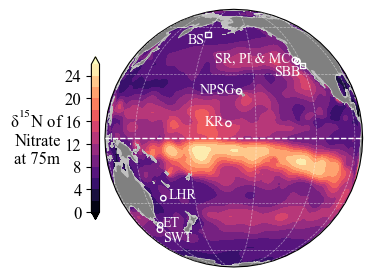

In [17]:
# load Rafter 2019 d15N ANN output into pandas dataframes and plot with site locations

#load Rafter et al., 2019 dataset into pandas dataframe
d15N_df=pd.read_csv(r'Datasets/dataset-768655_global-model-nitrate-d15n__v1.csv',
                 header=0)

#assign coordinates to indices in pandas 
d15N_df = d15N_df.set_index(['latitude', 'longitude','depth'])

# convert d15N pandas dataframe to xarray DataArray
d15N=d15N_df.to_xarray()
d15N=d15N.d15N

#select depth of interest (if choosing depth already in data)
depth=75
d15N_depth_sel=d15N.sel(depth=depth,method='nearest')

#uncomment this code segment below if want to interpolate to different depth:
# #--------------------------------------------------------------------------
# # to interpolate to any depth of choice, must convert dataset to xgcm Grid
# # and use xgcm Grid.transform to interpolate 
# depth=85 #set depth of interest
# # convert xarray dataset to xgcm Grid
# grid = Grid(d15N.to_dataset(), 
#             coords={'X': {'center':'longitude'},
#                     'Y': {'center':'latitude'},
#                     'Z': {'center': 'depth'}},
#             periodic=False)
# # create array with target depth
# target_depth_level = np.asarray([depth])
# # interpolate dataset to target depth
# d15N = grid.transform(d15N.to_dataset().d15N, 'Z', 
#                       target_depth_level, target_data=None, 
#                       method='linear')
# # convert from 3d to 2d for easier plotting by selecting only
# # depth of interest
# d15N_depthsel=d15N.sel(depth=depth)
# #--------------------------------------------------------------------------

#make map of sites with modern d15N NO3 from Rafter et al., 2019 

#create list of sampling sites labels from compiled observations
lats_obs=obs_summary.Latitude
lons_obs=obs_summary.Longitude

#set lat and lon coordinates where you want center of map to be
central_lon,central_lat=-160,0

# initialize plot
fig = plt.figure(figsize=(half_width,half_width))

#select map projection
proj='ortho'

#initialize subplot with chosen map projection
if proj== 'mollweide':
    ax = fig.add_subplot(1, 1, 1, projection=crs.Mollweide(central_longitude=central_lon))
    fraction=0.015
elif proj == 'robinson':
    ax = fig.add_subplot(1, 1, 1, projection=crs.Robinson(central_longitude=central_lon))
    fraction=0.015
elif proj in ['ortho','orthographic']:
    ax = fig.add_subplot(1, 1, 1, projection=crs.Orthographic(central_lon,central_lat))
    fraction=0.03
elif proj in ['pc','PlateCarree']:
    ax = fig.add_subplot(1, 1, 1, projection=crs.PlateCarree(central_longitude=central_lon))
    fraction=0.03
else:
    print("please select one of 'mollweide', 'robinson','pc' or 'ortho'")

#plot deep-sea coral study sites locations
plt.scatter(lons_obs.where(obs_summary['Coral?']==True),
            lats_obs.where(obs_summary['Coral?']==True),
            s=15,color='None',ec='w',
           linestyle='None',marker='o',
           transform=crs.PlateCarree(),zorder=10)
#plot sediment core study site locations
plt.scatter(lons_obs.where(obs_summary['Coral?']==False),
            lats_obs.where(obs_summary['Coral?']==False),
            s=15,color='None',ec='w',
           linestyle='None',marker='s',
           transform=crs.PlateCarree(),zorder=10)

# specify labels to add to each study site 
abbrev=['','','SR, PI & MC','NPSG','KR',
        'ET','SWT','LHR','BS','SBB']

#customize placement of each label
lons_shift=[0, 0, -4, -2, -2,
            4,  -5, 4, -1, -3]
lats_shift=[0, 0,  2,  1,  1,
            2, -5, 2, -3, -3]
ha=['left','left','right','right','right',
    'left','left','left','right','right']
for i in np.arange(0,len(abbrev)):
    ax.text(lons_obs[i]+lons_shift[i],
            lats_obs[i]+lats_shift[i],
            abbrev[i], 
            ha=ha[i],va='center',
            fontsize=10,rotation=0,
            color='w',transform=crs.PlateCarree())

# make filled contour plot of the Rafter et al 2019 
# nitrate d15N climatology at selected depth level
contour=ax.contourf(d15N.longitude, d15N.latitude, d15N_depth_sel,
                    levels=np.arange(0,26.1,2),extend='both',
                    cmap='magma',transform=crs.PlateCarree())

#add and configure colorbar settings
cbar=fig.colorbar(contour, orientation='vertical',
                  fraction=fraction, pad=0.02,location='left')
cbar.ax.tick_params(labelsize=12)
cbar.set_label('$\mathdefault{δ^{15}N}$ of\nNitrate\nat '+str(depth)+'m',
               rotation=0,va='center',labelpad=20,fontsize=12)

# add land masses to map
ax.add_feature(NaturalEarthFeature('physical', 'land', '110m'),
               edgecolor='silver',lw=.5,facecolor='grey',alpha=1,zorder=1)
ax.add_feature(NaturalEarthFeature('physical', 'ocean', '110m'),
               edgecolor='None',lw=0,facecolor='silver',alpha=1,zorder=-5)

#configure gridlines
gl=ax.gridlines(draw_labels=False, crs=crs.PlateCarree(),
             linewidth=.5, color='w', alpha=0.5, linestyle='--',zorder=5)
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,30))
gl.ylocator = mticker.FixedLocator(np.arange(-60,61,30))
gl2=ax.gridlines(draw_labels=False, ylocs=[0],  #special bold gridline for equator
             linewidth=1, color='w', alpha=1, linestyle='--',zorder=5)
gl2.xlines=False

#if projection is PlateCarree, set axis limits
# otherwise get to global coverage
if proj in ['pc','PlateCarree']:
    ax.set_extent([-240, -100, -65, 65],crs=crs.PlateCarree())
else:
    ax.set_global()

# add subplot label
# ax.text(0.02,0.98,'(a)',transform=ax.transAxes)

plt.savefig('Figures/Fig2.png',bbox_inches='tight', dpi=1000)
plt.savefig('Figures/Fig2.pdf',bbox_inches='tight', dpi=1000)
plt.show()

### Extract Mean d15N NO3 @ depth selected above at each study site from Rafter et al 2019 neural network climatology dataset

In [18]:
# copy the nitrate d15N climatology xarray Dataset
# and convert latitude from 0-360 to -180 to 180
# so it matches the paleo dataset coordinates
d15N_newlon=d15N
d15N_newlon.coords['longitude'] = (d15N.coords['longitude'] + 180) % 360 - 180
d15N_newlon = d15N_newlon.sortby(d15N.longitude)

# select depth of interest
d15N_depth_sel=d15N_newlon.sel(depth=depth)

# interpolate nitrate d15N climatology dataset to nearest longitude
# in order to fill nan values 
# (was a problem at a few sites very close to land) 
d15N_sel=d15N_depth_sel.interpolate_na(dim='longitude',method='nearest')

# create empty list to populate 
# with d15N NO3 values from each site 
d15N_NO3_list=[]

# loop through each study site,
# find d15N NO3 value at chosen depth
# that's closest to sampling location
for i in obs_summary.index:
    d15N_point=d15N_sel.sel(latitude=obs_summary['Latitude'].iloc[i],
                            longitude=obs_summary['Longitude'].iloc[i],
                            method='nearest')
    d15N_NO3_list.append(np.round(d15N_point.values,2))

# add d15N NO3 values for each study site 
# to the summary dataframe and display the values
obs_summary['d15N NO3']=d15N_NO3_list
display(obs_summary)

,Abbreviation,Coral?,Latitude,Longitude,Water Depth,rho_Phe,slope_Phe,rho_Lys,slope_Lys,rho_Glu,...,age,rho_Phe_pval_onetail,rho_Phe_pval_twotail,slope_Phe_pval_onetail,slope_Phe_pval_twotail,rho_Glu_pval_onetail,rho_Glu_pval_twotail,slope_Glu_pval_onetail,slope_Glu_pval_twotail,d15N NO3
0,SR,True,36.4,-122.3,1250,-0.71,-4.4,0.05,-0.0,0.63,...,"[1820.66666666666, 1822.08108108108, 1833.3243...",0.0022,0.0044,0.0128,0.0256,0.3077,0.6154,0.0128,0.0256,9.23
1,PI,True,37.4,-123.4,1300,-0.23,-4.1,0.00,-1.3,0.39,...,"[1, 3, 4, 5, 6, 8, 11, 14, 15, 16, 18, 19, 20,...",0.3289,0.6578,0.0211,0.0422,0.0226,0.0452,0.0211,0.0422,9.44
2,MC,True,36.7,-122.0,870,-0.68,-6.5,-0.14,-0.7,0.23,...,"[1, 2, 5, 8, 11, 13, 14, 15, 17, 18, 20, 21, 2...",0.0041,0.0082,0.0001,0.0002,0.0021,0.0042,0.0001,0.0002,9.23
3,NPSG,True,21.3,-157.5,450,-0.22,-1.1,-0.05,-0.7,0.80,...,"[1224, 1311, 1315, 1352, 1373, 1452, 1462, 150...",0.3438,0.6876,0.4597,0.9194,0.8644,1.7288,0.4597,0.9194,7.52
4,KR,True,6.4,-162.4,400,-0.73,-6.9,-0.43,-2.5,0.00,...,"[171, 426, 551, 704, 1276, 1400, 1636, 1813, 1...",0.0014,0.0028,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,13.61
5,ET,True,-42.5,149.2,1200,-0.80,-4.9,0.45,0.7,0.30,...,"[1940, 1961, 1970, 1970, 1975, 1980, 1988, 199...",0.0002,0.0004,0.0051,0.0102,0.0065,0.0130,0.0051,0.0102,6.82
6,SWT,True,-45.3,145.4,2400,-0.85,-7.3,-0.45,-4.6,-0.04,...,"[1900, 1913, 1921, 1922, 1931, 1939, 1946, 194...",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.03
7,LHR,True,-27.8,161.8,1550,-0.80,-5.6,-0.51,-2.3,0.72,...,"[1888, 1893, 1895, 1906, 1916, 1924, 1925, 193...",0.0002,0.0004,0.0007,0.0014,0.5874,1.1748,0.0007,0.0014,7.35
8,BS,False,53.4,-179.5,1300,-0.52,-3.8,-0.47,-4.3,0.48,...,"[6212.300884955752, 7513.185840707964, 9594.60...",0.0355,0.0710,0.0314,0.0628,0.0669,0.1338,0.0314,0.0628,6.52
9,SBB,False,34.2,-120.0,450,-0.44,-2.6,-0.11,-0.7,0.76,...,"[0.0, 1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 16.0, 22....",0.0778,0.1556,0.1402,0.2804,0.7361,1.4722,0.1402,0.2804,7.94



## **Section 4.2**

## Here we do some analysis combining mass-balance model results, observations from the deep-sea coral and sediment datasets, and Monte Carlo simulations based on expectations from amino acid isotope ecology. 


### **4.2.1** First we do monte carlo simulations with the ecosystem model to get an ensemble of model predictions based on parameter uncertainties

In [19]:
'''
Get ensemble of predicted d15N Phe values from 
Monte Carlo simulations with mass-balance
ecosystem model 
'''
TP_array=np.arange(1.01,3.00,.01)

simulated_dphe=[]
simulated_dglu=[]
dist='normal'
for i in range(0,10000):
    results_dict=d15N_model(TP=TP_array,            
                            eps_assim1=np.random.normal(5,1),    
                            eps_assim2=np.random.normal(10,2),
                            bulk_TEF=max(0.01,np.random.normal(3.5,1)),      
                            p_exc=max(0.01,np.random.normal(.4,.1)),   
                            d_sNO3=0,
                            p_NO3=.999,         
                            p_NH4=.999,         
                            beta_bulkphe=np.random.normal(-1.5,1),
                            beta_gluphe=np.random.normal(3.3,1.8), #Ramirez et al., 2021
                            TDF_Glu=np.random.normal(7.6,1.2), #Chikaraishi et al., 2009      
                            TEF_Phe=np.random.normal(0,.5),  #Chikaraishi et al., 2009     
                            NO3_model='open',  
                            NH4_model='open')
    results = SimpleNamespace(**results_dict)
    simulated_dphe.append(results.d_phe)
    simulated_dglu.append(results.d_glu)
    i=i+1

# get model predicted TP-Phe slope 90% confidence intervals and median
model_slope_TPPhe_upperenv=scipy.stats.scoreatpercentile([scipy.stats.linregress(TP_array,simulated_dphe[x])[0] for x in range(0,10000)],95)
model_slope_TPPhe_median=scipy.stats.scoreatpercentile([scipy.stats.linregress(TP_array,simulated_dphe[x])[0] for x in range(0,10000)],50)
model_slope_TPPhe_lowerenv=scipy.stats.scoreatpercentile([scipy.stats.linregress(TP_array,simulated_dphe[x])[0] for x in range(0,10000)],5)
model_slope_TPPhe_std=np.std([scipy.stats.linregress(TP_array,simulated_dphe[x])[0] for x in range(0,10000)],ddof=1)
model_intercept_TPPhe_median=scipy.stats.scoreatpercentile([scipy.stats.linregress(TP_array,simulated_dphe[x])[1] for x in range(0,10000)],50)

# get model predicted TP-Glu slope 90% confidence intervals and median
model_slope_TPGlu_upperenv=scipy.stats.scoreatpercentile([scipy.stats.linregress(TP_array,simulated_dglu[x])[0] for x in range(0,10000)],95)
model_slope_TPGlu_median=scipy.stats.scoreatpercentile([scipy.stats.linregress(TP_array,simulated_dglu[x])[0] for x in range(0,10000)],50)
model_slope_TPGlu_lowerenv=scipy.stats.scoreatpercentile([scipy.stats.linregress(TP_array,simulated_dglu[x])[0] for x in range(0,10000)],5)
model_slope_TPGlu_std=np.std([scipy.stats.linregress(TP_array,simulated_dglu[x])[0] for x in range(0,10000)],ddof=1)
model_intercept_TPGlu_median=scipy.stats.scoreatpercentile([scipy.stats.linregress(TP_array,simulated_dglu[x])[1] for x in range(0,10000)],50)

# get median values and 90% confidence envelopes for modeled Phe values
model_Phe_upper_env=[scipy.stats.scoreatpercentile(np.transpose(simulated_dphe)[x],95) for x in range(0,len(TP_array))]
model_Phe_median=[scipy.stats.scoreatpercentile(np.transpose(simulated_dphe)[x],50) for x in range(0,len(TP_array))]
model_Phe_lower_env=[scipy.stats.scoreatpercentile(np.transpose(simulated_dphe)[x],5) for x in range(0,len(TP_array))]

# get median values and 90% confidence envelopes for modeled Glu values
model_Glu_upper_env=[scipy.stats.scoreatpercentile(np.transpose(simulated_dglu)[x],95) for x in range(0,len(TP_array))]
model_Glu_median=[scipy.stats.scoreatpercentile(np.transpose(simulated_dglu)[x],50) for x in range(0,len(TP_array))]
model_Glu_lower_env=[scipy.stats.scoreatpercentile(np.transpose(simulated_dglu)[x],5) for x in range(0,len(TP_array))]

# print slope predictions from mass-balance model
print('TP Phe model slope median +/- stdev (90% CI)=',round(model_slope_TPPhe_median,3),'+/-', round(model_slope_TPPhe_std,3),
      '(',round(model_slope_TPPhe_lowerenv,3),'to',round(model_slope_TPPhe_upperenv,3),')')
print('TP Glu model slope median +/- stdev (90% CI)=',round(model_slope_TPGlu_median,3),'+/-', round(model_slope_TPGlu_std,3),
      '(',round(model_slope_TPGlu_lowerenv,3),'to',round(model_slope_TPGlu_upperenv,3),')')

TP Phe model slope median +/- stdev (90% CI)= -3.506 +/- 1.096 ( -5.3 to -1.677 )
TP Glu model slope median +/- stdev (90% CI)= 4.078 +/- 1.622 ( 1.463 to 6.792 )


### **4.2.2** Calculate ∆δ<sup>15</sup>N<sub>Glu</sub>, ∆δ<sup>15</sup>N<sub>Phe</sub>, ∆δ<sup>15</sup>N<sub>Lys</sub> and adjust TP values for archive type, then calculate the slope of the relationships between TP and Phe, TP and GLu and TP and Lys across all adjusted datasets

In [20]:
# first create empty columns in the observatiosn summary dataframe
# to fill in with adjusted TP, Glu, Phe and Lys values

obs_summary['TP_adj'] = np.empty(len(obs_summary.index)).astype('object')
obs_summary['Glu_adj'] = np.empty(len(obs_summary.index)).astype('object')
obs_summary['Phe_adj'] = np.empty(len(obs_summary.index)).astype('object')
obs_summary['Lys_adj'] = np.empty(len(obs_summary.index)).astype('object')

for i in obs_summary.index:
    if obs_summary['Coral?'][i]==True:
        # correct TP, Glu, Phe for offset between coral
        # and dietary POM (from TEF and polyp-skeleton offset (d))
        obs_summary.at[i,'TP_adj']=np.asarray(obs_summary['TP'][i])-1
        obs_summary.at[i,'Glu_adj']=np.asarray(obs_summary['Glu'][i])-obs_summary['d15N NO3'][i]-8+3.4
        obs_summary.at[i,'Phe_adj']=np.asarray(obs_summary['Phe'][i])-obs_summary['d15N NO3'][i]-0.4
        obs_summary.at[i,'Lys_adj']=np.asarray(obs_summary['Lys'][i])-obs_summary['d15N NO3'][i]-0.8 #0.8 from mcmahon et al
    else:
        # no TP correction needed for sediment datasets
        obs_summary.at[i,'TP_adj']=np.asarray(obs_summary['TP'][i])
        obs_summary.at[i,'Glu_adj']=np.asarray(obs_summary['Glu'][i])-obs_summary['d15N NO3'][i]
        obs_summary.at[i,'Phe_adj']=np.asarray(obs_summary['Phe'][i])-obs_summary['d15N NO3'][i]
        obs_summary.at[i,'Lys_adj']=np.asarray(obs_summary['Lys'][i])-obs_summary['d15N NO3'][i]

# Create arrays with all adjusted data from all datasets together
TP_adj_obs=np.concatenate(obs_summary['TP_adj'], axis=None).ravel()
Phe_adj_obs=np.concatenate(obs_summary['Phe_adj'], axis=None).ravel()
Glu_adj_obs=np.concatenate(obs_summary['Glu_adj'], axis=None).ravel()
Lys_adj_obs=np.concatenate(obs_summary['Lys_adj'], axis=None).ravel()

# remove pre-Holocene data from dataset
age=np.concatenate(obs_summary['age'], axis=None).ravel()
mask=age < 12000
TP_adj_obs_hol=TP_adj_obs[mask]
Phe_adj_obs_hol=Phe_adj_obs[mask]
Glu_adj_obs_hol=Glu_adj_obs[mask]
Lys_adj_obs_hol=Lys_adj_obs[mask]

# Create arrays with all adjusted data from all datasets except SWT together
obs_summary_noSWT=obs_summary[obs_summary['Abbreviation']!='SWT'].reset_index()

TP_adj_obs_noSWT=np.concatenate(obs_summary_noSWT['TP_adj'], axis=None).ravel()
Phe_adj_obs_noSWT=np.concatenate(obs_summary_noSWT['Phe_adj'], axis=None).ravel()
Glu_adj_obs_noSWT=np.concatenate(obs_summary_noSWT['Glu_adj'], axis=None).ravel()
Lys_adj_obs_noSWT=np.concatenate(obs_summary_noSWT['Lys_adj'], axis=None).ravel()

# remove pre-Holocene data from dataset (no SWT)
age=np.concatenate(obs_summary_noSWT['age'], axis=None).ravel()
mask=age < 12000
TP_adj_obs_hol_noSWT=TP_adj_obs_noSWT[mask]
Phe_adj_obs_hol_noSWT=Phe_adj_obs_noSWT[mask]
Glu_adj_obs_hol_noSWT=Glu_adj_obs_noSWT[mask]
Lys_adj_obs_hol_noSWT=Lys_adj_obs_noSWT[mask]

# get regression coefficients from across all adjusted datasets
# (Holocene data only)
m_Phe_obs,b_Phe_obs=scipy.stats.linregress(TP_adj_obs_hol_noSWT,Phe_adj_obs_hol_noSWT)[0:2]
m_Glu_obs,b_Glu_obs=scipy.stats.linregress(TP_adj_obs_hol_noSWT,Glu_adj_obs_hol_noSWT)[0:2]
m_Lys_obs,b_Lys_obs=scipy.stats.linregress(TP_adj_obs_hol_noSWT,Lys_adj_obs_hol_noSWT)[0:2]

# print regression results
print('TP Phe regression relationship from observations:\n','Phe = ',round(m_Phe_obs,2),'x TP +',round(b_Phe_obs,2))
print('TP Glu regression relationship from observations:\n','Glu = ',round(m_Glu_obs,2),'x TP +',round(b_Glu_obs,2))
print('TP Lys regression relationship from observations:\n','Lys = ',round(m_Lys_obs,2),'x TP +',round(b_Lys_obs,2))

TP Phe regression relationship from observations:
 Phe =  -4.94 x TP + 7.05
TP Glu regression relationship from observations:
 Glu =  2.66 x TP + 2.85
TP Lys regression relationship from observations:
 Lys =  -3.38 x TP + 6.03


### **4.2.3** Find fit of ∆δ<sup>15</sup>N<sub>Glu</sub> and ∆δ<sup>15</sup>N<sub>Phe</sub> to median model predictions based on R<sup>2</sup> and RMSE. Also find fit of ∆δ<sup>15</sup>N<sub>Lys</sub> observations to regression:

In [21]:
#find R^2 of fit between model prediction and all observations
# and then all observations except the SWT time series
m_Phe_model=scipy.stats.linregress(TP_array,model_Phe_median)[0]
b_Phe_model=scipy.stats.linregress(TP_array,model_Phe_median)[1]
m_Glu_model=scipy.stats.linregress(TP_array,model_Glu_median)[0]
b_Glu_model=scipy.stats.linregress(TP_array,model_Glu_median)[1]

R_sq_all_Phe=r2_func(x_obs=TP_adj_obs_hol,y_obs=Phe_adj_obs_hol,
                 m=m_Phe_model,b=b_Phe_model)
R_sq_noSWT_Phe=r2_func(x_obs=TP_adj_obs_hol_noSWT,y_obs=Phe_adj_obs_hol_noSWT,
                 m=m_Phe_model,b=b_Phe_model)
RMSE_all_Phe=rmse_func(x_obs=TP_adj_obs_hol,y_obs=Phe_adj_obs_hol,
                 m=m_Phe_model,b=b_Phe_model)
RMSE_noSWT_Phe=rmse_func(x_obs=TP_adj_obs_hol_noSWT,y_obs=Phe_adj_obs_hol_noSWT,
                 m=m_Phe_model,b=b_Phe_model)

print('m Phe observed =',m_Phe_obs)
print('b Phe observed =',b_Phe_obs)
print('m Phe modeled =',m_Phe_model)
print('b Phe modeled =',b_Phe_model)
print('Phe R^2 (without SWT) =',R_sq_noSWT_Phe)
print('Phe R^2 (with SWT) =',R_sq_all_Phe)
print('Phe RMSE (without SWT) =',RMSE_noSWT_Phe)
print('Phe RMSE (with SWT) =',RMSE_all_Phe)

R_sq_all_Glu=r2_func(x_obs=TP_adj_obs_hol,y_obs=Glu_adj_obs_hol,
                    m=m_Glu_model,b=b_Glu_model)
R_sq_noSWT_Glu=r2_func(x_obs=TP_adj_obs_hol_noSWT,y_obs=Glu_adj_obs_hol_noSWT,
                 m=m_Glu_model,b=b_Glu_model)
RMSE_all_Glu=rmse_func(x_obs=TP_adj_obs_hol,y_obs=Glu_adj_obs_hol,
                 m=m_Glu_model,b=b_Glu_model)
RMSE_noSWT_Glu=rmse_func(x_obs=TP_adj_obs_hol_noSWT,y_obs=Glu_adj_obs_hol_noSWT,
                 m=m_Glu_model,b=b_Glu_model)

print('m Glu observed =',m_Glu_obs)
print('b Glu observed =',b_Glu_obs)
print('m Glu modeled =',m_Glu_model)
print('b Glu modeled =',b_Glu_model)
print('Glu R^2 (without SWT) =',R_sq_noSWT_Glu)
print('Glu R^2 (with SWT) =',R_sq_all_Glu)
print('Glu RMSE (without SWT) =',RMSE_noSWT_Glu)
print('Glu RMSE (with SWT) =',RMSE_all_Glu)

R_sq_all_Lys=r2_func(x_obs=TP_adj_obs_hol,y_obs=Lys_adj_obs_hol,
                    m=m_Lys_obs,b=b_Lys_obs)
R_sq_noSWT_Lys=r2_func(x_obs=TP_adj_obs_hol_noSWT,y_obs=Lys_adj_obs_hol_noSWT,
                 m=m_Lys_obs,b=b_Lys_obs)
RMSE_all_Lys=rmse_func(x_obs=TP_adj_obs_hol,y_obs=Lys_adj_obs_hol,
                    m=m_Lys_obs,b=b_Lys_obs)
RMSE_noSWT_Lys=rmse_func(x_obs=TP_adj_obs_hol_noSWT,y_obs=Lys_adj_obs_hol_noSWT,
                 m=m_Lys_obs,b=b_Lys_obs)

print('m Lys observed =',m_Lys_obs)
print('b Lys observed =',b_Lys_obs)
print('Lys R^2 (without SWT) =',R_sq_noSWT_Lys)
print('Lys R^2 (with SWT) =',R_sq_all_Lys)
print('Lys RMSE (without SWT) =',RMSE_noSWT_Lys)
print('Lys RMSE (with SWT) =',RMSE_all_Lys)

m Phe observed = -4.939492223110655
b Phe observed = 7.05343521465899
m Phe modeled = -3.505002358410223
b Phe modeled = 5.000322145878677
Phe R^2 (without SWT) = 0.651230184342203
Phe R^2 (with SWT) = 0.13204855547241612
Phe RMSE (without SWT) = 1.5638200172303331
Phe RMSE (with SWT) = 2.729934942770314
m Glu observed = 2.660507776889349
b Glu observed = 2.853435214658984
m Glu modeled = 4.067551714607262
b Glu modeled = 0.6861536218380451
Glu R^2 (without SWT) = 0.2990171156972441
Glu R^2 (with SWT) = 0.2529174515609335
Glu RMSE (without SWT) = 1.5111254067266164
Glu RMSE (with SWT) = 2.6602150144247645
m Lys observed = -3.3811636940391128
b Lys observed = 6.03088798037694
Lys R^2 (without SWT) = 0.6626662411400199
Lys R^2 (with SWT) = 0.038498451464220484
Lys RMSE (without SWT) = 1.1231467127399253
Lys RMSE (with SWT) = 2.3007824033725157


In [22]:
len(TP_adj_obs_hol_noSWT)

153

### Figure 5a: Show predicted Phe and Glu from ecosystem model and conventional CSI-AA theory along with observations

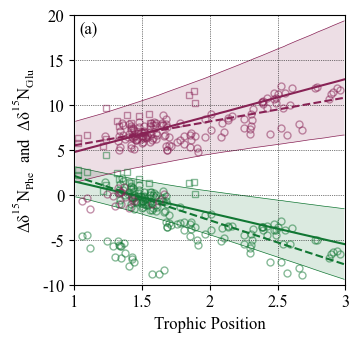

In [23]:
# set colors to use
phe_color=color_dict['phy']
glu_color=color_dict['zoo2']

#set markers
sedmarker='s'#'#CC7AA0'#
coralmarker='o'#'#126C7A'

# initialize plot 
fig,ax=plt.subplots(figsize=(half_width,half_width))

#Plot TP vs Phe from mass-balance model
plt.plot(TP_array,model_Phe_median,linestyle='-',color=phe_color)

#plot 90% confidence envelope for Phe ecosystem model results
plt.fill_between(x=TP_array,y1=model_Phe_upper_env,y2=model_Phe_lower_env,fc=phe_color,alpha=.15,zorder=-5)
plt.plot(TP_array,model_Phe_upper_env,lw=.5,color=phe_color,linestyle='-',alpha=1,zorder=-5)
plt.plot(TP_array,model_Phe_lower_env,lw=.5,color=phe_color,linestyle='-',alpha=1,zorder=-5)

#Plot TP vs Glu from mass-balance model
plt.plot(TP_array,model_Glu_median,linestyle='-',color=glu_color)

#plot 90% confidence envelope for Glu ecosystem model results
plt.fill_between(x=TP_array,y1=model_Glu_upper_env,y2=model_Glu_lower_env,fc=glu_color,alpha=.15,zorder=-5)
plt.plot(TP_array,model_Glu_upper_env,lw=.5,color=glu_color,linestyle='-',alpha=1,zorder=-5)
plt.plot(TP_array,model_Glu_lower_env,lw=.5,color=glu_color,linestyle='-',alpha=1,zorder=-5)

# loop through the compiled paleo datasets
# plotting TP vs d15N Phe and d15N Glu
# normalized to d15N NO3 from the Rafter et al., 2019 dataset
# at the corresponding study site at the chosen depth 
for i in obs_summary.index:
    if obs_summary['Coral?'][i]==True:
        m_sel=coralmarker #select color
    else:
        m_sel= sedmarker
        
    # plot TP vs Phe points (Holocene only)
    temp_df=obs_summary[obs_summary.index==i]
    hol_subset=pd.DataFrame(data={'age':np.asarray(temp_df['age'].tolist()).ravel(),
                                  'TP_adj':np.asarray(temp_df['TP_adj'].tolist()).ravel(),
                                  'Phe_adj':np.asarray(temp_df['Phe_adj'].tolist()).ravel(),
                                  'Glu_adj':np.asarray(temp_df['Glu_adj'].tolist()).ravel(),
                                 })
    hol_subset=hol_subset[hol_subset['age']<12000]
                            
    ax.plot(hol_subset['TP_adj'],
             hol_subset['Phe_adj'],
             linestyle='None',color='None',
             mec=phe_color,alpha=.5,ms=5,
             marker=m_sel,
             label=obs_summary['Abbreviation'][i])

    # plot TP vs Glu points
    ax.plot(hol_subset['TP_adj'],
             hol_subset['Glu_adj'],
             linestyle='None',color='None',
             mec=glu_color,alpha=.5,ms=5,
             marker=m_sel,
             label=obs_summary['Abbreviation'][i])

# Plot the TP-Phe regression line
# from across all paleo datasets
# (Holocene only)
x=np.asarray([1,3])
plt.plot(x,m_Phe_obs*x+b_Phe_obs,linestyle='--',alpha=1,
         lw=1.5,color=phe_color)

# Plot the TP-Phe regression line
# from across all paleo datasets
# (Holocene only)
plt.plot(x,m_Glu_obs*x+b_Glu_obs,linestyle='--',alpha=1,
         lw=1.5,color=glu_color)

# set axis labels
ax.set_xlabel('Trophic Position')
ax.set_ylabel('$\mathdefault{Δδ^{15}N_{Phe}}$  and  $\mathdefault{Δδ^{15}N_{Glu}}$')

#set axis limits
ax.set_xlim(1,3)
ax.set_ylim(-10,20)

#set axis label format
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

# move y axis ticks and axis label to right
ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()

# add gridlines
ax.grid(linestyle=':',lw=.5,color='k')

# add subplot label
text=ax.text(0.02,0.98,'(a)',ha='left',va='top',transform=ax.transAxes,
            bbox=dict(boxstyle='square,pad=0',alpha=.5, fc='w', ec='none'))

#save figure, display and close
plt.savefig('Figures/Fig5a_alt.png',bbox_inches='tight', dpi=1000)
plt.savefig('Figures/Fig5a_alt.pdf',bbox_inches='tight', dpi=1000)
plt.show()
plt.close()

In [24]:
hol_subset

,age,TP_adj,Phe_adj,Glu_adj
0,0.0,0.973684,2.06,5.26
1,1.0,1.092105,2.56,6.66
2,3.0,1.315789,2.46,8.26
3,5.0,1.026316,2.16,5.76
4,7.0,1.236842,4.46,9.66
5,9.0,1.552632,1.36,8.96
6,11.0,1.421053,1.36,7.96
7,16.0,1.473684,0.16,7.16
8,22.0,1.026316,2.76,6.36
9,28.0,1.210526,0.46,5.46


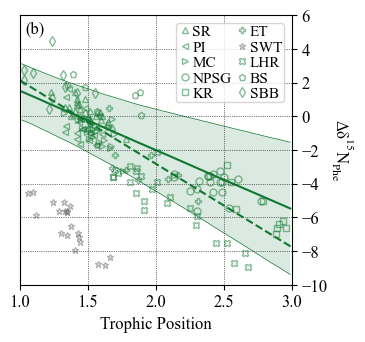

In [25]:
### Fig 5b with ecosystem mass-balance model uncertainty from Monte Carlo simulations

'''
Make plot
'''
# set markers to used for each study site
marker_list=['^','<','>','o','s',
             'P','*','X','p','d']

# set colors to use
sedcolor=color_dict['phy']#'#D186B4'#'#CC7AA0'#
coralcolor=color_dict['phy']#'#A78AE6'#'#126C7A'
greycolor=color_dict['phy']

# initialize plot 
fig,ax=plt.subplots(figsize=(half_width,half_width))

#plot mass balance model results
plt.plot(TP_array,model_Phe_median,linestyle='-',color=greycolor,lw=1.5,zorder=-20)

#plot uncertainty envelope for mass balance model results
plt.fill_between(x=TP_array,y1=model_Phe_upper_env,y2=model_Phe_lower_env,fc=greycolor,alpha=.15,zorder=-5)
plt.plot(TP_array,model_Phe_upper_env,lw=.5,color=greycolor,linestyle='-',alpha=1,zorder=-5)
plt.plot(TP_array,model_Phe_lower_env,lw=.5,color=greycolor,linestyle='-',alpha=1,zorder=-5)

# loop through the compiled paleo datasets
# plotting TP vs d15N Phe
# normalized to d15N NO3 from the Rafter et al., 2019 dataset
# at the corresponding study site at the chosen depth 
k=0
for i in obs_summary.index:
    if obs_summary['Abbreviation'][i] == 'SWT':
        color_sel='dimgrey'
    else:
        color_sel=phe_color
    m_sel=marker_list[k]
    k=k+1
        
    # plot TP vs Phe points (Holocene only)
    temp_df=obs_summary[obs_summary.index==i]
    hol_subset=pd.DataFrame(data={'age':np.asarray(temp_df['age'].tolist()).ravel(),
                                  'TP_adj':np.asarray(temp_df['TP_adj'].tolist()).ravel(),
                                  'Phe_adj':np.asarray(temp_df['Phe_adj'].tolist()).ravel(),
                                 })
    hol_subset=hol_subset[hol_subset['age']<12000]
                            
    ax.plot(hol_subset['TP_adj'],
             hol_subset['Phe_adj'],
             linestyle='None',color='None',
             mec=color_sel,alpha=.5,ms=5,
             marker=m_sel,
             label=obs_summary['Abbreviation'][i])

plt.plot(x,m_Phe_obs*x+b_Phe_obs,linestyle='--',alpha=1,
         lw=1.5,color=phe_color)

# set axis labels
ax.set_xlabel('Trophic Position')
ax.set_ylabel('$\mathdefault{Δδ^{15}N_{Phe}}$',
             rotation=270,labelpad=20)

#set axis limits
ax.set_xlim(1,3)
ax.set_ylim(-10,6)

# move y axis ticks and axis label to right
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

# add gridlines
ax.grid(linestyle=':',color='k',lw=.5)

# add legend
ax.legend(fontsize=11,labelspacing=.1,handlelength=1,
          handletextpad=0,borderpad=0.1,
          ncol=2,columnspacing=.2,
          loc='upper right',bbox_to_anchor=(1,1))

# add subplot label
text=ax.text(0.02,0.98,'(b)',ha='left',va='top',transform=ax.transAxes,
            bbox=dict(boxstyle='square,pad=0',alpha=.5, fc='w', ec='none'))

#save figure, display and close
plt.savefig('Figures/Fig5b.png',bbox_inches='tight', dpi=1000)
plt.savefig('Figures/Fig5b.pdf',bbox_inches='tight', dpi=1000)
plt.show()
plt.close()

### Supplementary figures TP vs Lys

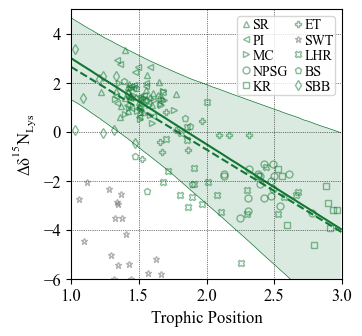

,Abbreviation,Coral?,Latitude,Longitude,Water Depth,rho_Phe,slope_Phe,rho_Lys,slope_Lys,rho_Glu,...,slope_Phe_pval_twotail,rho_Glu_pval_onetail,rho_Glu_pval_twotail,slope_Glu_pval_onetail,slope_Glu_pval_twotail,d15N NO3,TP_adj,Glu_adj,Phe_adj,Lys_adj
0,SR,True,36.4,-122.3,1250,-0.71,-4.4,0.05,-0.0,0.63,...,0.0256,0.3077,0.6154,0.0128,0.0256,9.23,"[1.646791979949871, 1.4369590643274868, 1.5026...","[7.9485714285714, 7.177777777777701, 7.0357777...","[-0.3670476190476212, 0.4568888888888004, -0.1...","[2.0349047619046994, 1.4557777777777001, 1.208..."
1,PI,True,37.4,-123.4,1300,-0.23,-4.1,0.00,-1.3,0.39,...,0.0422,0.0226,0.0452,0.0211,0.0422,9.44,"[1.5032894736842106, 1.6016447368421045, 1.579...","[5.796300000000002, 6.892299999999999, 7.79641...","[-1.4286999999999987, -1.0801999999999974, -0....","[0.5923500000000004, 0.6583499999999993, 2.642..."
2,MC,True,36.7,-122.0,870,-0.68,-6.5,-0.14,-0.7,0.23,...,0.0002,0.0021,0.0042,0.0001,0.0002,9.23,"[1.5067105263157892, 1.3958114035087714, 1.579...","[5.877000000000001, 6.498833333333332, 6.29983...","[-1.374, 0.09066666666666767, -1.5052083333333...","[0.4999999999999989, 0.7210000000000008, 0.681..."
3,NPSG,True,21.3,-157.5,450,-0.22,-1.1,-0.05,-0.7,0.80,...,0.9194,0.8644,1.7288,0.4597,0.9194,7.52,"[2.1315789473684212, 2.5, 2.486842105263158, 2...","[8.38, 11.180000000000001, 10.78, 8.58, 11.88,...","[-3.6199999999999997, -3.6199999999999997, -3....","[-1.72, -1.8199999999999996, -1.31999999999999..."
4,KR,True,6.4,-162.4,400,-0.73,-6.9,-0.43,-2.5,0.00,...,0.0000,0.0000,0.0000,0.0000,0.0000,13.61,"[2.552631578947368, 2.8947368421052633, 2.9342...","[11.290000000000001, 11.19, 11.890000000000002...","[-3.9099999999999997, -6.609999999999999, -6.2...","[-1.8099999999999998, -2.9099999999999993, -3...."
5,ET,True,-42.5,149.2,1200,-0.80,-4.9,0.45,0.7,0.30,...,0.0102,0.0065,0.0130,0.0051,0.0102,6.82,"[1.8644736842105258, 2.310526315789474, 1.7776...","[6.159999999999998, 8.31, 6.15, 7.970000000000...","[-3.81, -5.050000000000001, -3.160000000000000...","[-0.7500000000000002, -0.1399999999999999, 0.0..."
6,SWT,True,-45.3,145.4,2400,-0.85,-7.3,-0.45,-4.6,-0.04,...,0.0000,0.0000,0.0000,0.0000,0.0000,8.03,"[1.4039473684210524, 1.3671052631578946, 1.115...","[-1.4599999999999995, 0.8700000000000006, -1.5...","[-7.93, -5.32, -5.859999999999999, -7.18999999...","[-4.169999999999999, -2.5599999999999996, -2.0..."
7,LHR,True,-27.8,161.8,1550,-0.80,-5.6,-0.51,-2.3,0.72,...,0.0014,0.5874,1.1748,0.0007,0.0014,7.35,"[1.8631578947368421, 1.8921052631578945, 1.855...","[6.900000000000002, 6.609999999999999, 5.33000...","[-3.059999999999999, -3.57, -4.57, -3.61999999...","[-3.0699999999999994, -2.6799999999999997, -0...."
8,BS,False,53.4,-179.5,1300,-0.52,-3.8,-0.47,-4.3,0.48,...,0.0628,0.0669,0.1338,0.0314,0.0628,6.52,"[1.561998746867168, 1.4705263157894737, 1.8904...","[8.005000000000003, 6.878833333333333, 10.2140...","[0.3338095238095242, -0.09716666666666729, 0.0...","[-2.4135714285714283, -0.9748333333333328, -2...."
9,SBB,False,34.2,-120.0,450,-0.44,-2.6,-0.11,-0.7,0.76,...,0.2804,0.7361,1.4722,0.1402,0.2804,7.94,"[0.9736842105263157, 1.0921052631578947, 1.315...","[5.259999999999999, 6.659999999999999, 8.25999...","[2.0599999999999996, 2.5599999999999996, 2.46,...","[0.15999999999999925, 1.3600000000000003, 0.05..."


In [26]:
# TP vs Lys (not corrected for Lys trophic fractionation)

#initialize plot
fig,ax=plt.subplots(figsize=(half_width,half_width))

#plot mass balance model results
plt.plot(TP_array,np.asarray(model_Phe_median)+1.5,linestyle='-',color=greycolor,lw=1.5,zorder=-20)

#plot uncertainty envelope for mass balance model results
plt.fill_between(x=TP_array,y1=np.asarray(model_Phe_upper_env)+1.5,y2=np.asarray(model_Phe_lower_env)+1.5,fc=greycolor,alpha=.15,zorder=-5)
plt.plot(TP_array,np.asarray(model_Phe_upper_env)+1.5,lw=.5,color=greycolor,linestyle='-',alpha=1,zorder=-5)
plt.plot(TP_array,np.asarray(model_Phe_lower_env)+1.5,lw=.5,color=greycolor,linestyle='-',alpha=1,zorder=-5)

# loop through the compiled paleo datasets
# plotting TP vs d15N Lys
# normalized to d15N NO3 from the Rafter et al., 2019 dataset
# at the corresponding study site at the chosen depth 
k=0
for i in obs_summary.index:
    if obs_summary['Abbreviation'][i] == 'SWT':
        color_sel='dimgrey'
    else:
        color_sel=phe_color
    m_sel=marker_list[k]
    k=k+1
        
    # plot TP vs Lys points (Holocene only)
    temp_df=obs_summary[obs_summary.index==i]
    hol_subset=pd.DataFrame(data={'age':np.asarray(temp_df['age'].tolist()).ravel(),
                                  'TP_adj':np.asarray(temp_df['TP_adj'].tolist()).ravel(),
                                  'Lys_adj':np.asarray(temp_df['Lys_adj'].tolist()).ravel(),
                                 })
    hol_subset=hol_subset[hol_subset['age']<12000]
                        
    ax.plot(hol_subset['TP_adj'],
             hol_subset['Lys_adj'],
             linestyle='None',color='None',
             mec=color_sel,alpha=.5,ms=5,
             marker=m_sel,
             label=obs_summary['Abbreviation'][i])

# calculate slope and intercept for the TP-Lys
# regression across all paleo datasets and plot
# and also calculate R^2
x=np.asarray([1,3])
plt.plot(x,m_Lys_obs*x+b_Lys_obs,linestyle='--',alpha=1,
         lw=1.5,color=phe_color)

#set axis labels
ax.set_xlabel('Trophic Position')
ax.set_ylabel('$\mathdefault{Δδ^{15}N_{Lys}}$')

#set axis limits
ax.set_xlim(1,3)
ax.set_ylim(-6,5)

#add gridlines
ax.grid(linestyle=':',color='k',lw=.5)

#add legend
ax.legend(fontsize=10,labelspacing=.1,handlelength=1,
          handletextpad=0,borderpad=0.1,
          ncol=2,columnspacing=.2,
          loc='upper right',bbox_to_anchor=(1,1))


plt.savefig('Figures/Supplemental_TPvLys_withSWT.png',bbox_inches='tight', dpi=1000)
plt.show()
plt.close()

display(obs_summary)

In [27]:
for i in obs_summary.index:
    print(obs_summary['Abbreviation'][i])

SR
PI
MC
NPSG
KR
ET
SWT
LHR
BS
SBB


NameError: name 'time' is not defined

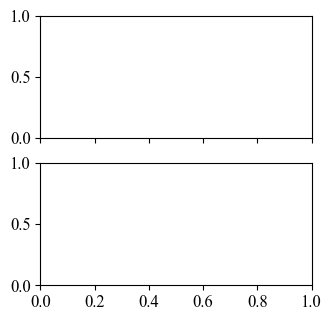

In [28]:
# time=np.arange(2,98.1,8)
# Phe_true=np.full(len(time),0)
# Glu_true=Phe_true+3.4+7.6
# TP_true=((Glu_true-Phe_true-3.4)/7.6)+1

# Phe_error=Phe_true+np.random.normal(0,.7,size=len(time))
# Glu_error=Glu_true#+np.random.normal(0,.7,size=len(time))
# TP_error=((Glu_error-Phe_error-3.4)/7.6)+1

fig,axs=plt.subplots(2,1,figsize=(half_width,half_width),sharex='all')
axs[0].plot(time,Phe_true,color=color_dict['phy'],linestyle='--',label='True d15N phe')
axs[1].plot(time,TP_true,color=color_dict['zoo2'],linestyle='--',label='True TP')
axs[0].plot(time,Phe_error,color=color_dict['phy'],linestyle='-',marker='o',label='d15N phe + meas. error')
axs[1].plot(time,TP_error,color=color_dict['zoo2'],linestyle='-',marker='o',label='TP + meas. error')

axs[0].set_xlim(0,100)
axs[0].set_ylim(-2,2)
axs[1].set_ylim(1.8,2.2)

axs[1].set_xlabel('Time')
axs[0].set_ylabel('$\mathdefault{δ^{15}N_{Phe}}$')
axs[1].set_ylabel('TP')

axs[0].grid(linestyle=':',color='k',lw=.5)
axs[1].grid(linestyle=':',color='k',lw=.5)

axs[0].yaxis.set_major_locator(mticker.MultipleLocator(base=1))
axs[1].yaxis.set_major_locator(mticker.MultipleLocator(base=.1))

axs[0].legend(fontsize=8,labelspacing=0,frameon=False,
             loc='upper left',bbox_to_anchor=(0,.3))
axs[1].legend(fontsize=8,labelspacing=0,frameon=False,
             loc='upper left',bbox_to_anchor=(0,.3))

plt.savefig('example_spurious_corr.png',dpi=400,bbox_inches='tight')
plt.show()
plt.close()

fig,ax=plt.subplots(figsize=(2,2))
plt.plot(TP_error,Phe_error,linestyle='None',marker='o',color='k')
ax.set_xlabel('TP')
ax.set_ylabel('$\mathdefault{δ^{15}N_{Phe}}$')

# f-ratio calculation

In [ ]:
import copernicusmarine
copernicusmarine.login()
# catalogue=copernicusmarine.describe(include_datasets = True, contains = ['cmems_mod_glo_bgc_my_0.083deg-lmtl_PT1D-i'])
# print(catalogue)
# ?copernicusmarine.subset
# lon_min,lon_max,lat_min,lat_max=-126.5,-115.8,32,43.5
copernicusmarine.subset(dataset_id='cmems_mod_glo_bgc_my_0.083deg-lmtl_PT1D-i',
                        variables=["npp"],
                        start_datetime="2010-01-01T00:00:00",
                        end_datetime="2019-12-31T23:59:59",
                        output_filename = "chl_a_monthly_cmems_2010to2019.nc",
                        output_directory = "copernicus-data")

In [ ]:
?copernicusmarine.get

In [ ]:
import copernicusmarine

In [ ]:
copernicusmarine.login()

In [ ]:
catalogue=copernicusmarine.describe(include_datasets = True, contains = ['cmems_mod_glo_bgc_my_0.083deg-lmtl_PT1D-i'])
print(catalogue)